In [152]:

! pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
# load library
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import warnings
import re
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import AdamW, get_linear_schedule_with_warmup
warnings.filterwarnings('ignore')

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-06 13:05:52.620368: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 13:05:53.113343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 13:05:55.249279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
# load data
train = pd.read_csv("train.csv")
# raw data 기준 중복행 표시
train['drop'] = 1
train['drop'][list(train.drop_duplicates().index)] = 0
# test data
test = pd.read_csv("submission.csv")

In [3]:
df_train = train.copy()
df_test = test.copy()

# preprocessing

## customer_country

customer_country는 행마다 데이터가 입련된 형식이 상이한 경우가 많아 train data에서의 전처리 방식을 unseen(test) data에 일반화하기 어렵다고 판단하여 drop  

## business_subarea

In [156]:
# Business subarea 데이터 중에서 Others라는 항목이 있는데, 이는 상위항목인 business area에 대하여 groupby 했을 때 각 category마다 존재하는 것을 확인할 수 있음
# 따라서 business subarea의 Others를 각각 해당되는 business area에 맞게 재분류 
df_train.loc[(df_train.business_area == 'corporate / office') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-corporate/office'
df_train.loc[(df_train.business_area == 'education') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-education'
df_train.loc[(df_train.business_area == 'factory') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-facotry'
df_train.loc[(df_train.business_area == 'government department') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-government_department'
df_train.loc[(df_train.business_area == 'hospital & health care') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-hospital&health_care'
df_train.loc[(df_train.business_area == 'hotel & accommodation') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-hotel&accommodation'
df_train.loc[(df_train.business_area == 'power plant / renewable energy') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-power/energy'
df_train.loc[(df_train.business_area == 'public facility') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-public'
df_train.loc[(df_train.business_area == 'residential (home)') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-residental'
df_train.loc[(df_train.business_area == 'retail') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'Other Stores'
df_train.loc[(df_train.business_area == 'special purpose') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-speical'
df_train.loc[(df_train.business_area == 'transportation') & (df_train.business_subarea == 'Others'),'business_subarea'] = 'others-transportaion'

df_test.loc[(df_test.business_area == 'corporate / office') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-corporate/office'
df_test.loc[(df_test.business_area == 'education') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-education'
df_test.loc[(df_test.business_area == 'factory') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-facotry'
df_test.loc[(df_test.business_area == 'government department') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-government_department'
df_test.loc[(df_test.business_area == 'hospital & health care') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-hospital&health_care'
df_test.loc[(df_test.business_area == 'hotel & accommodation') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-hotel&accommodation'
df_test.loc[(df_test.business_area == 'power plant / renewable energy') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-power/energy'
df_test.loc[(df_test.business_area == 'public facility') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-public'
df_test.loc[(df_test.business_area == 'residential (home)') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-residental'
df_test.loc[(df_test.business_area == 'retail') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'Other Stores'
df_test.loc[(df_test.business_area == 'special purpose') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-speical'
df_test.loc[(df_test.business_area == 'transportation') & (df_test.business_subarea == 'Others'),'business_subarea'] = 'others-transportaion'

In [157]:
train['business_subarea'] = df_train['business_subarea']
test['business_subarea'] = df_test['business_subarea']

## customer_type

In [158]:
# (train data 기준) 대소문자, 띄어쓰기, 하이픈 표시로 인해 분리된 카테고리
train.loc[train['customer_type']=='End Customer', 'customer_type'] = 'End-Customer'
train.loc[train['customer_type']=='Homeowner', 'customer_type'] = 'Home Owner'
train.loc[train['customer_type']=='Others', 'customer_type'] = 'Other'

In [159]:
# train코드 test에 동일하게 적용
test.loc[test['customer_type']=='End Customer', 'customer_type'] = 'End-Customer'
test.loc[test['customer_type']=='Homeowner', 'customer_type'] = 'Home Owner'
test.loc[test['customer_type']=='Others', 'customer_type'] = 'Other'

## customer_job

In [160]:
#특수기호 '_', '.'로 인한 구분 일괄 처리
for i in list(train.loc[train['customer_job'].notnull()].index):
  train['customer_job'][i] = train['customer_job'][i].replace('.', '').replace('_', ' ').replace('\u200b', '').strip()

#unique job_list
job_list = list(train['customer_job'].unique())
job_list.remove(np.nan)
fix_dict = {}

# 상위 빈도 직업군을 위주로 filtering 방식의 일괄 통합
# 특정 토큰/표제어/어간 string이 포함되어있는지 여부를 기준으로 통합

# engineering
fix_list = []
for job in [x for x in job_list if 'engine' in x]: # ex : engine이 포함된 직업군
  train.loc[train['customer_job']==job, 'customer_job'] = 'engineering' #상위 빈도 engineering으로 통합
  job_list.remove(job)
  fix_list.append(job)
fix_dict['engineering'] = fix_list

#administrative
fix_list = []
for job in [x for x in job_list if ('admin' in x) & ('it' not in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'administrative'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['administrative'] = fix_list

#education
fix_list = []
for job in [x for x in job_list if 'educ' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'education'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['education'] = fix_list

#arts and design
fix_list = []
for job in [x for x in job_list if ('design' in x) or ('art' in x) and ('part' not in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'arts and design'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['arts and design'] = fix_list

#information technology
fix_list = []
for job in [x for x in job_list if ('it ' in x) or (' it' in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'information technology'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['information technology'] = fix_list

# program and project management
fix_list = []
for job in [x for x in job_list if 'project manage' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'program and project management'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['program and project management'] = fix_list

# media and communication
fix_list = []
for job in [x for x in job_list if 'media' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'media and communication'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['media and communication'] = fix_list

#purchasing
fix_list = []
for job in [x for x in job_list if ('purchas' in x) & ('install' not in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'purchasing'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['purchasing'] = fix_list

# marketing
fix_list = []
for job in [x for x in job_list if 'market' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'marketing'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['marketing'] = fix_list

# research
fix_list = []
for job in [x for x in job_list if 'research' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'research'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['research'] = fix_list

# ceo
fix_list = []
for job in [x for x in job_list if 'execut' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'ceo'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['ceo'] = fix_list

# sales
fix_list = []
for job in [x for x in job_list if 'sale' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'sales'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['sales'] = fix_list

# manager
fix_list = []
for job in [x for x in job_list if ('project' not in x) & ('manag' in x) & ('product manage' not in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'manager'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['manager'] = fix_list

# consulting
fix_list = []
for job in [x for x in job_list if 'consult' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'consulting'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['consulting'] = fix_list

# other
fix_list = []
for job in [x for x in job_list if (' tv' in x)|('wall' in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'other'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['other'] = fix_list

# hospital
fix_list = []
for job in [x for x in job_list if ('medical' in x)|('clinic' in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'hospital'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['hospital'] = fix_list

# recommend
fix_list = []
for job in [x for x in job_list if 'recommend' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'recommend'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['recommend'] = fix_list

# contractor
fix_list = []
for job in [x for x in job_list if 'contract' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'contractor'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['contractor'] = fix_list

# technical
fix_list = []
for job in [x for x in job_list if ('tech' in x) & ('information technology' not in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'technical'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['technical'] = fix_list

# architect
fix_list = []
for job in [x for x in job_list if 'archi' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'architect'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['architect'] = fix_list

# installer
fix_list = []
for job in [x for x in job_list if 'install' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'installer'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['installer'] = fix_list

# director
fix_list = []
for job in [x for x in job_list if ('direct' in x) & ('operation' not in x) & ('finance' not in x) & ('it' not in x) & ('project' not in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'director'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['director'] = fix_list

# operations
fix_list = []
for job in [x for x in job_list if 'operation' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'operations'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['operations'] = fix_list

# quote
fix_list = []
for job in [x for x in job_list if 'quot' in x]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'quote'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['quote'] = fix_list

# coordinator
fix_list = []
for job in [x for x in job_list if ('coord' in x) & ('buyer' not in x) & ('procure' not in x)]:
  train.loc[train['customer_job']==job, 'customer_job'] = 'coordinator'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['coordinator'] = fix_list

# signage
fix_list = []
for job in [x for x in job_list if ('sign' in x) | ('display' in x)]:
  if 'design' not in job:
    train.loc[train['customer_job']==job, 'customer_job'] = 'signage'
    job_list.remove(job)
    fix_list.append(job)
fix_dict['signage'] = fix_list

#토큰/표제어/어간이 포함되어있지는 않지만, 거리가 가까운 직업군은 직접 병합

# engineer
train.loc[(train['customer_job']=='repair uhd 120 hz units')|
          (train['customer_job']=='electronics evaluator')|
          (train['customer_job']=='elevator company'), 'customer_job'] = 'engineering'
# sales
train.loc[(train['customer_job']=='sale')|
          (train['customer_job']=='reseller/integrator')|
          (train['customer_job']=='reseller')|
          (train['customer_job']=='revendedor')|
          (train['customer_job']=='vendor / reseller')|
          (train['customer_job']=='sales rep'), 'customer_job'] = 'sales'
# arts and design
train.loc[(train['customer_job']=='museum / gallery')|
          (train['customer_job']=='colorist'), 'customer_job'] = 'arts and design'
# ceo
# 최고/상위경영진의 의미를 담은 직업 모두 ceo로 통일
train.loc[(train['customer_job']=='owner')|
          (train['customer_job']=='executive')|
          (train['customer_job']=='lead')|
          (train['customer_job']=='president')|
          (train['customer_job']=='coo')|
          (train['customer_job']=='ceo/founder')|
          (train['customer_job']=='principal in charge')|
          (train['customer_job']=='entrepreneurship')|
          (train['customer_job']=='head')|
          (train['customer_job']=='the big boss')|
          (train['customer_job']=='owning company')|
          (train['customer_job']=='business owner')|
          (train['customer_job']=='leader')|
          (train['customer_job']=='chief')|
          (train['customer_job']=='owner representation')|
          (train['customer_job']=='vice president')|
          (train['customer_job']=='commander')|
          (train['customer_job']=='underboss')|
          (train['customer_job']=='president for sennco')|
          (train['customer_job']=='master mind'), 'customer_job'] = 'ceo'
# information technology
train.loc[(train['customer_job']=='it') |
          (train['customer_job']=='it/software') |
          (train['customer_job']=='director,it') |
          (train['customer_job']=='software developer') |
          (train['customer_job']=='developer') |
          (train['customer_job']=='developer/property') |
          (train['customer_job']=='application development') |
          (train['customer_job']=='cloud / mobility') |
          (train['customer_job']=='software solution'), 'customer_job'] = 'information technology'
# operations
train.loc[(train['customer_job']=='operations manager')|
          (train['customer_job']=='director of operations'), 'customer_job'] = 'operations'
# purchasing
train.loc[train['customer_job']=='purchsing', 'customer_job'] = 'purchasing'
# finance
train.loc[(train['customer_job']=='asset management') |
          (train['customer_job']=='stakeholder') |
          (train['customer_job']=='director of finance'), 'customer_job'] = 'finance'
# accounting
train.loc[(train['customer_job']=='accounts payable')|
          (train['customer_job']=='account exec/manager')|
          (train['customer_job']=='pricing'), 'customer_job'] = 'accounting'
# decision maker
train.loc[(train['customer_job']=='authorize (you are responsible for making the final decision)') |
          (train['customer_job']=='decider') |
          (train['customer_job']=='final approval'), 'customer_job'] = 'decision maker'
# manager
train.loc[(train['customer_job']=='gm') |
          (train['customer_job']=='projection manager') |
          (train['customer_job']=='product management') |
          (train['customer_job']=='manger') |
          (train['customer_job']=='supervisor') |
          (train['customer_job']=='maintenance supervisor') |
          (train['customer_job']=='vp/gm') |
          (train['customer_job']=='gm/part owner') |
          (train['customer_job']=='ops mgr'), 'customer_job'] = 'manager'
# program and project management
train.loc[(train['customer_job']=='pm') |
          (train['customer_job']=='project team member') |
          (train['customer_job']=='project lead') |
          (train['customer_job']=='project head') |
          (train['customer_job']=='project director') |
          (train['customer_job']=='project facilitator') |
          (train['customer_job']=='projectr mgmt') |
          (train['customer_job']=='team lead') |
          (train['customer_job']=='team leader') |
          (train['customer_job']=='projektmenedzsment\tprogram and project management') |
          (train['customer_job']=='programm- und projektmanagement'), 'customer_job'] = 'program and project management'
# education
train.loc[(train['customer_job']=='teacher') |
          (train['customer_job']=='instructor') |
          (train['customer_job']=='teaching')|
          (train['customer_job']=='institute & academy') |
          (train['customer_job']=='principal'), 'customer_job'] = 'education'
# human resources
train.loc[(train['customer_job']=='hr') |
          (train['customer_job']=='hr posting'), 'customer_job'] = 'human resources'
#technical
train.loc[(train['customer_job']=='tech') |
          (train['customer_job']=='electronics & telco'), 'customer_job'] = 'technical'
# other
train.loc[(train['customer_job']=='others') |
          (train['customer_job']=='other stores'), 'customer_job'] = 'other'
# real estate
train.loc[(train['customer_job']=='building owner') |
          (train['customer_job']=='property owner'), 'customer_job'] = 'real estate'
# hospital
train.loc[(train['customer_job']=='surgery professional') |
          (train['customer_job']=='healthcare professionals')|
          (train['customer_job']=='radiology  professional')|
          (train['customer_job']=='radiology professional')|
          (train['customer_job']=='pathologist')|
          (train['customer_job']=='doctor'), 'customer_job'] = 'hospital'
# marketing
train.loc[(train['customer_job']=='advertising')|
          (train['customer_job']=='advertising and promotions team')|
          (train['customer_job']=='store promotions'), 'customer_job'] = 'marketing'
# architect
train.loc[(train['customer_job']=='architect ass interiores')|
          (train['customer_job']=='interior stylist'), 'customer_job'] = 'architect'
# analyst
train.loc[train['customer_job']=='associate/analyst', 'customer_job'] = 'analyst'
# curation
train.loc[train['customer_job']=='quotation curator', 'customer_job'] = 'curation'
# restaurant
train.loc[(train['customer_job']=='serving food')|
          (train['customer_job']=='serving robot')|
          (train['customer_job']=='serving')|
          (train['customer_job']=='chef')|
          (train['customer_job']=='waiter')|
          (train['customer_job']=='assist in serving food')|
          (train['customer_job']=='restaurant display'), 'customer_job'] = 'restaurant'
# end user
train.loc[(train['customer_job']=='user')|
          (train['customer_job']=='primary end-user')|
          (train['customer_job']=='main end user of the product')|
          (train['customer_job']=='cliente final'), 'customer_job'] = 'end user'
# procurement
train.loc[(train['customer_job']=='procurement specialist')|
          (train['customer_job']=='equipment and app provider')|
          (train['customer_job']=='procurment')|
          (train['customer_job']=='sourcing')|
          (train['customer_job']=='supplier')|
          (train['customer_job']=='sourcing / procurement')|
          (train['customer_job']=='development coordinator/procurement')|
          (train['customer_job']=='sourcing/procurement'), 'customer_job'] = 'procurement'
# integrator
train.loc[(train['customer_job']=='integrador')|
          (train['customer_job']=='intergrator')|
          (train['customer_job']=='specifier / integrator')|
          (train['customer_job']=='integration'), 'customer_job'] = 'integrator'
# distributor
train.loc[(train['customer_job']=='distribuidor')|
          (train['customer_job']=='distributor quotation'), 'customer_job'] = 'distributor'
# planner
train.loc[(train['customer_job']=='equipment planner')|
          (train['customer_job']=='enterprise resource planning'), 'customer_job'] = 'planner'
# consulting
train.loc[(train['customer_job']=='solution provider')|
          (train['customer_job']=='solution advisor')|
          (train['customer_job']=='solutions provider and specifier')|
          (train['customer_job']=='recommend'), 'customer_job'] = 'consulting'
# quality assurance
train.loc[(train['customer_job']=='testing and troubleshooting')|
          (train['customer_job']=='tester'), 'customer_job'] = 'quality assurance'
# helpdesk
train.loc[(train['customer_job']=='helpdesk specialist')|
          (train['customer_job']=='help desk / desktop services'), 'customer_job'] = 'helpdesk'
# contractor
train.loc[(train['customer_job']=='general contractor')|
          (train['customer_job']=='cintractor'), 'customer_job'] = 'contractor'
# cctv
train.loc[(train['customer_job']=='cctv monetoring')|
          (train['customer_job']=='cctv view'), 'customer_job'] = 'cctv'
# buyer
train.loc[(train['customer_job']=='buyer, coordinating')|
          (train['customer_job']=='requirements and buyer'), 'customer_job'] = 'buyer'
# photo
train.loc[(train['customer_job']=='photographer')|
          (train['customer_job']=='photos'), 'customer_job'] = 'photo'
# research
train.loc[train['customer_job']=='investigator', 'customer_job'] = 'research'
# administrative
train.loc[train['customer_job']=='facility administrator', 'customer_job'] = 'administrative'
# manufacturer
train.loc[train['customer_job']=='manufacturing factory / plant', 'customer_job'] = 'manufacturer'
# healthcare services
train.loc[train['customer_job']=='mental health', 'customer_job'] = 'healthcare services'
# installer
train.loc[train['customer_job']=='si', 'customer_job'] = 'installer'
# bidder
train.loc[train['customer_job']=='public bidder', 'customer_job'] = 'bidder'
# coordinator
train.loc[train['customer_job']=='organizer', 'customer_job'] = 'coordinator'
# facilitator
train.loc[train['customer_job']=='facilities', 'customer_job'] = 'facilitator'
# intern
train.loc[train['customer_job']=='entry level', 'customer_job'] = 'intern'
# community and social services
train.loc[train['customer_job']=='community theater', 'customer_job'] = 'community and social services'
# na
train['customer_job'] = train['customer_job'].replace('na', np.NaN)

# 외국어
# 영어 이외의 언어로 기재되었으나 동일 의미로 간주되는 경우 해당 직업으로 통합
# finance
train.loc[(train['customer_job']=='finanzen') | # finanzen : 독일어
          (train['customer_job']=='finanzas')| # finanzas
          (train['customer_job']=='pénzügy'), 'customer_job'] = 'finance' # pénzügy : 헝가리어
#sales
train.loc[(train['customer_job']=='értékesítés')| # értékesítés : 헝가리어
          (train['customer_job']=='vertrieb')| # vertrieb : 독일어
          (train['customer_job']=='vendite'), 'customer_job'] = 'sales' # vendite : 이탈리아어
# other
train.loc[(train['customer_job']=='sonstiges') |
          (train['customer_job']=='otro')|
          (train['customer_job']=='otros') |
          (train['customer_job']=='egyéb') |
          (train['customer_job']=='autres')|
          (train['customer_job']=='altro'), 'customer_job'] = 'other'
# arte y diseño : 스페인어 -> art and design
train.loc[train['customer_job']=='arte y diseño', 'customer_job'] = 'art and design'
# amministrativo : 이탈리아어 -> administrative
train.loc[train['customer_job']=='amministrativo', 'customer_job'] = 'administrative'
# real estate
train.loc[train['customer_job']=='proprietário(a)', 'customer_job'] = 'real estate' # proprietário(a) : 포르투갈어
# hospital
train.loc[(train['customer_job']=='chirurgien')| # chirurgien : 프랑스어 외과의사
          (train['customer_job']=='cirugano') | # cirugano : 스페인어 외과의사
          (train['customer_job']=='főorvos') | # főorvos : 헝가리어 종합병원장
          (train['customer_job']=='tierarzt')| # tierarzt : 독일어 수의사
          (train['customer_job']=='profesional de cirugía')| # profesional de cirugía : 스페인어
          (train['customer_job']=='spécialiste en imagerie médicale')|
          (train['customer_job']=='profesional de radiología'), 'customer_job'] = 'other'
# program and project management
train.loc[(train['customer_job']=='gestión de proyectos') | # gestión de proyectos : 스페인어
          (train['customer_job']=='program- és projektmenedzsment'), 'customer_job'] = 'program and project management' # program- és projektmenedzsment
# operations
train.loc[(train['customer_job']=='operaciones') | # operaciones : 스페인어
          (train['customer_job']=='üzemeltetés'), 'customer_job'] = 'operations' # üzemeltetés : 헝가리어
# manager
train.loc[train['customer_job']=='managgere', 'customer_job'] = 'manager'
# education
train.loc[train['customer_job']=='genel müdür', 'customer_job'] = 'education'
# media and communication
train.loc[(train['customer_job']=='medien und kommunikation') | # medien und kommunikation
          (train['customer_job']=='medios de comunicación') |
          (train['customer_job']=='média és kommunikáció'), 'customer_job'] = 'media and communication' # média és kommunikáció
# train에서 빈도 1회인 경우 other로 처리 -> 처리한 단어는 모두 test에도 동일하게 적용
one_count = [x[0] for x in list(Counter(train['customer_job']).most_common()) if x[1]==1]
fix_list = []
for job in one_count:
  train.loc[train['customer_job']==job, 'customer_job'] = 'other'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['other'] = fix_list

In [161]:
# train code를 test에 동일하게 적용

#특수기호 '_', '.'로 인한 구분 일괄 처리
for i in list(test.loc[test['customer_job'].notnull()].index):
  test['customer_job'][i] = test['customer_job'][i].replace('.', '').replace('_', ' ').replace('\u200b', '').strip()

#unique job_list
job_list = list(test['customer_job'].unique())
job_list.remove(np.nan)
fix_dict = {}

# engineering
fix_list = []
for job in [x for x in job_list if 'engine' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'engineering'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['engineering'] = fix_list

#administrative
fix_list = []
for job in [x for x in job_list if ('admin' in x) & ('it' not in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'administrative'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['administrative'] = fix_list

#education
fix_list = []
for job in [x for x in job_list if 'educ' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'education'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['education'] = fix_list

#arts and design
fix_list = []
for job in [x for x in job_list if ('design' in x) or ('art' in x) and ('part' not in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'arts and design'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['arts and design'] = fix_list

#information technology
fix_list = []
for job in [x for x in job_list if ('it ' in x) or (' it' in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'information technology'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['information technology'] = fix_list

# program and project management
fix_list = []
for job in [x for x in job_list if 'project manage' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'program and project management'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['program and project management'] = fix_list

# media and communication
fix_list = []
for job in [x for x in job_list if 'media' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'media and communication'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['media and communication'] = fix_list

#purchasing
fix_list = []
for job in [x for x in job_list if ('purchas' in x) & ('install' not in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'purchasing'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['purchasing'] = fix_list

# marketing
fix_list = []
for job in [x for x in job_list if 'market' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'marketing'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['marketing'] = fix_list

# research
fix_list = []
for job in [x for x in job_list if 'research' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'research'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['research'] = fix_list

# ceo
fix_list = []
for job in [x for x in job_list if 'execut' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'ceo'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['ceo'] = fix_list

# sales
fix_list = []
for job in [x for x in job_list if 'sale' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'sales'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['sales'] = fix_list

# manager
fix_list = []
for job in [x for x in job_list if ('project' not in x) & ('manag' in x) & ('product manage' not in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'manager'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['manager'] = fix_list

# consulting
fix_list = []
for job in [x for x in job_list if 'consult' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'consulting'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['consulting'] = fix_list

# other
fix_list = []
for job in [x for x in job_list if (' tv' in x)|('wall' in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'other'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['other'] = fix_list

# hospital
fix_list = []
for job in [x for x in job_list if ('medical' in x)|('clinic' in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'hospital'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['hospital'] = fix_list

# recommend
fix_list = []
for job in [x for x in job_list if 'recommend' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'recommend'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['recommend'] = fix_list

# contractor
fix_list = []
for job in [x for x in job_list if 'contract' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'contractor'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['contractor'] = fix_list

# technical
fix_list = []
for job in [x for x in job_list if ('tech' in x) & ('information technology' not in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'technical'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['technical'] = fix_list

# architect
fix_list = []
for job in [x for x in job_list if 'archi' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'architect'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['architect'] = fix_list

# installer
fix_list = []
for job in [x for x in job_list if 'install' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'installer'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['installer'] = fix_list

# director
fix_list = []
for job in [x for x in job_list if ('direct' in x) & ('operation' not in x) & ('finance' not in x) & ('it' not in x) & ('project' not in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'director'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['director'] = fix_list

# operations
fix_list = []
for job in [x for x in job_list if 'operation' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'operations'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['operations'] = fix_list

# quote
fix_list = []
for job in [x for x in job_list if 'quot' in x]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'quote'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['quote'] = fix_list

# coordinator
fix_list = []
for job in [x for x in job_list if ('coord' in x) & ('buyer' not in x) & ('procure' not in x)]:
  test.loc[test['customer_job']==job, 'customer_job'] = 'coordinator'
  job_list.remove(job)
  fix_list.append(job)
fix_dict['coordinator'] = fix_list

# signage
fix_list = []
for job in [x for x in job_list if ('sign' in x) | ('display' in x)]:
  if 'design' not in job:
    test.loc[test['customer_job']==job, 'customer_job'] = 'signage'
    job_list.remove(job)
    fix_list.append(job)
fix_dict['signage'] = fix_list

# engineer
test.loc[(test['customer_job']=='repair uhd 120 hz units')|
          (test['customer_job']=='electronics evaluator')|
          (test['customer_job']=='elevator company'), 'customer_job'] = 'engineering'
# sales
test.loc[(test['customer_job']=='sale')|
          (test['customer_job']=='reseller/integrator')|
          (test['customer_job']=='reseller')|
          (test['customer_job']=='revendedor')|
          (test['customer_job']=='vendor / reseller')|
          (test['customer_job']=='sales rep'), 'customer_job'] = 'sales'
# arts and design
test.loc[(test['customer_job']=='museum / gallery')|
          (test['customer_job']=='colorist'), 'customer_job'] = 'arts and design'
# ceo
test.loc[(test['customer_job']=='owner')|
          (test['customer_job']=='executive')|
          (test['customer_job']=='lead')|
          (test['customer_job']=='president')|
          (test['customer_job']=='coo')|
          (test['customer_job']=='ceo/founder')|
          (test['customer_job']=='principal in charge')|
          (test['customer_job']=='entrepreneurship')|
          (test['customer_job']=='head')|
          (test['customer_job']=='the big boss')|
          (test['customer_job']=='owning company')|
          (test['customer_job']=='business owner')|
          (test['customer_job']=='leader')|
          (test['customer_job']=='chief')|
          (test['customer_job']=='owner representation')|
          (test['customer_job']=='vice president')|
          (test['customer_job']=='commander')|
          (test['customer_job']=='underboss')|
          (test['customer_job']=='president for sennco')|
          (test['customer_job']=='master mind'), 'customer_job'] = 'ceo'
# information technology
test.loc[(test['customer_job']=='it') |
          (test['customer_job']=='it/software') |
          (test['customer_job']=='director,it') |
          (test['customer_job']=='software developer') |
          (test['customer_job']=='developer') |
          (test['customer_job']=='developer/property') |
          (test['customer_job']=='application development') |
          (test['customer_job']=='cloud / mobility') |
          (test['customer_job']=='software solution'), 'customer_job'] = 'information technology'
# operations
test.loc[(test['customer_job']=='operations manager')|
          (test['customer_job']=='director of operations'), 'customer_job'] = 'operations'
# purchasing
test.loc[test['customer_job']=='purchsing', 'customer_job'] = 'purchasing'
# finance
test.loc[(test['customer_job']=='asset management') |
          (test['customer_job']=='stakeholder') |
          (test['customer_job']=='director of finance'), 'customer_job'] = 'finance'
# accounting
test.loc[(test['customer_job']=='accounts payable')|
          (test['customer_job']=='account exec/manager')|
          (test['customer_job']=='pricing'), 'customer_job'] = 'accounting'
# decision maker
test.loc[(test['customer_job']=='authorize (you are responsible for making the final decision)') |
          (test['customer_job']=='decider') |
          (test['customer_job']=='final approval'), 'customer_job'] = 'decision maker'
# manager
test.loc[(test['customer_job']=='gm') |
          (test['customer_job']=='projection manager') |
          (test['customer_job']=='product management') |
          (test['customer_job']=='manger') |
          (test['customer_job']=='supervisor') |
          (test['customer_job']=='maintenance supervisor') |
          (test['customer_job']=='vp/gm') |
          (test['customer_job']=='gm/part owner') |
          (test['customer_job']=='ops mgr'), 'customer_job'] = 'manager'
# program and project management
test.loc[(test['customer_job']=='pm') |
          (test['customer_job']=='project team member') |
          (test['customer_job']=='project lead') |
          (test['customer_job']=='project head') |
          (test['customer_job']=='project director') |
          (test['customer_job']=='project facilitator') |
          (test['customer_job']=='projectr mgmt') |
          (test['customer_job']=='team lead') |
          (test['customer_job']=='team leader') |
          (test['customer_job']=='projektmenedzsment\tprogram and project management') |
          (test['customer_job']=='programm- und projektmanagement'), 'customer_job'] = 'program and project management'
# education
test.loc[(test['customer_job']=='teacher') |
          (test['customer_job']=='instructor') |
          (test['customer_job']=='teaching')|
          (test['customer_job']=='institute & academy') |
          (test['customer_job']=='principal'), 'customer_job'] = 'education'
# human resources
test.loc[(test['customer_job']=='hr') |
          (test['customer_job']=='hr posting'), 'customer_job'] = 'human resources'
#technical
test.loc[(test['customer_job']=='tech') |
          (test['customer_job']=='electronics & telco'), 'customer_job'] = 'technical'
# other
test.loc[(test['customer_job']=='others') |
          (test['customer_job']=='other stores'), 'customer_job'] = 'other'
# real estate
test.loc[(test['customer_job']=='building owner') |
          (test['customer_job']=='property owner'), 'customer_job'] = 'real estate'
# hospital
test.loc[(test['customer_job']=='surgery professional') |
          (test['customer_job']=='healthcare professionals')|
          (test['customer_job']=='radiology  professional')|
          (test['customer_job']=='radiology professional')|
          (test['customer_job']=='pathologist')|
          (test['customer_job']=='doctor'), 'customer_job'] = 'hospital'
# marketing
test.loc[(test['customer_job']=='advertising')|
          (test['customer_job']=='advertising and promotions team')|
          (test['customer_job']=='store promotions'), 'customer_job'] = 'marketing'
# architect
test.loc[(test['customer_job']=='architect ass interiores')|
          (test['customer_job']=='interior stylist'), 'customer_job'] = 'architect'
# analyst
test.loc[test['customer_job']=='associate/analyst', 'customer_job'] = 'analyst'
# curation
test.loc[test['customer_job']=='quotation curator', 'customer_job'] = 'curation'
# restaurant
test.loc[(test['customer_job']=='serving food')|
          (test['customer_job']=='serving robot')|
          (test['customer_job']=='serving')|
          (test['customer_job']=='chef')|
          (test['customer_job']=='waiter')|
          (test['customer_job']=='assist in serving food')|
          (test['customer_job']=='restaurant display'), 'customer_job'] = 'restaurant'
# end user
test.loc[(test['customer_job']=='user')|
          (test['customer_job']=='primary end-user')|
          (test['customer_job']=='main end user of the product')|
          (test['customer_job']=='cliente final'), 'customer_job'] = 'end user'
# procurement
test.loc[(test['customer_job']=='procurement specialist')|
          (test['customer_job']=='equipment and app provider')|
          (test['customer_job']=='procurment')|
          (test['customer_job']=='sourcing')|
          (test['customer_job']=='supplier')|
          (test['customer_job']=='sourcing / procurement')|
          (test['customer_job']=='development coordinator/procurement')|
          (test['customer_job']=='sourcing/procurement'), 'customer_job'] = 'procurement'
# integrator
test.loc[(test['customer_job']=='integrador')|
          (test['customer_job']=='intergrator')|
          (test['customer_job']=='specifier / integrator')|
          (test['customer_job']=='integration'), 'customer_job'] = 'integrator'
# distributor
test.loc[(test['customer_job']=='distribuidor')|
          (test['customer_job']=='distributor quotation'), 'customer_job'] = 'distributor'
# planner
test.loc[(test['customer_job']=='equipment planner')|
          (test['customer_job']=='enterprise resource planning'), 'customer_job'] = 'planner'
# consulting
test.loc[(test['customer_job']=='solution provider')|
          (test['customer_job']=='solution advisor')|
          (test['customer_job']=='solutions provider and specifier')|
          (test['customer_job']=='recommend'), 'customer_job'] = 'consulting'
# quality assurance
test.loc[(test['customer_job']=='testing and troubleshooting')|
          (test['customer_job']=='tester'), 'customer_job'] = 'quality assurance'
# helpdesk
test.loc[(test['customer_job']=='helpdesk specialist')|
          (test['customer_job']=='help desk / desktop services'), 'customer_job'] = 'helpdesk'
# contractor
test.loc[(test['customer_job']=='general contractor')|
          (test['customer_job']=='cintractor'), 'customer_job'] = 'contractor'
# cctv
test.loc[(test['customer_job']=='cctv monetoring')|
          (test['customer_job']=='cctv view'), 'customer_job'] = 'cctv'
# buyer
test.loc[(test['customer_job']=='buyer, coordinating')|
          (test['customer_job']=='requirements and buyer'), 'customer_job'] = 'buyer'
# photo
test.loc[(test['customer_job']=='photographer')|
          (test['customer_job']=='photos'), 'customer_job'] = 'photo'
# research
test.loc[test['customer_job']=='investigator', 'customer_job'] = 'research'
# administrative
test.loc[test['customer_job']=='facility administrator', 'customer_job'] = 'administrative'
# manufacturer
test.loc[test['customer_job']=='manufacturing factory / plant', 'customer_job'] = 'manufacturer'
# healthcare services
test.loc[test['customer_job']=='mental health', 'customer_job'] = 'healthcare services'
# installer
test.loc[test['customer_job']=='si', 'customer_job'] = 'installer'
# bidder
test.loc[test['customer_job']=='public bidder', 'customer_job'] = 'bidder'
# coordinator
test.loc[test['customer_job']=='organizer', 'customer_job'] = 'coordinator'
# facilitator
test.loc[test['customer_job']=='facilities', 'customer_job'] = 'facilitator'
# intern
test.loc[test['customer_job']=='entry level', 'customer_job'] = 'intern'
# community and social services
test.loc[test['customer_job']=='community theater', 'customer_job'] = 'community and social services'
# na
test['customer_job'] = test['customer_job'].replace('na', np.NaN)

# 외국어
# finance
test.loc[(test['customer_job']=='finanzen') | # finanzen : 독일어
          (test['customer_job']=='finanzas')| # finanzas
          (test['customer_job']=='pénzügy'), 'customer_job'] = 'finance' # pénzügy : 헝가리어
#sales
test.loc[(test['customer_job']=='értékesítés')| # értékesítés : 헝가리어
          (test['customer_job']=='vertrieb')| # vertrieb : 독일어
          (test['customer_job']=='vendite'), 'customer_job'] = 'sales' # vendite : 이탈리아어
# other(4852)
test.loc[(test['customer_job']=='sonstiges') |
          (test['customer_job']=='otro')|
          (test['customer_job']=='otros') |
          (test['customer_job']=='egyéb') |
          (test['customer_job']=='autres')|
          (test['customer_job']=='altro'), 'customer_job'] = 'other'
# arte y diseño : 스페인어 -> art and design
test.loc[test['customer_job']=='arte y diseño', 'customer_job'] = 'art and design'
# amministrativo : 이탈리아어 -> administrative
test.loc[test['customer_job']=='amministrativo', 'customer_job'] = 'administrative'
# real estate
test.loc[test['customer_job']=='proprietário(a)', 'customer_job'] = 'real estate' # proprietário(a) : 포르투갈어
# hospital
test.loc[(test['customer_job']=='chirurgien')| # chirurgien : 프랑스어 외과의사
          (test['customer_job']=='cirugano') | # cirugano : 스페인어 외과의사
          (test['customer_job']=='főorvos') | # főorvos : 헝가리어 종합병원장
          (test['customer_job']=='tierarzt')| # tierarzt : 독일어 수의사
          (test['customer_job']=='profesional de cirugía')| # profesional de cirugía : 스페인어
          (test['customer_job']=='spécialiste en imagerie médicale')|
          (test['customer_job']=='profesional de radiología'), 'customer_job'] = 'other'
# program and project management
test.loc[(test['customer_job']=='gestión de proyectos') | # gestión de proyectos : 스페인어
          (test['customer_job']=='program- és projektmenedzsment'), 'customer_job'] = 'program and project management' # program- és projektmenedzsment
# operations
test.loc[(test['customer_job']=='operaciones') | # operaciones : 스페인어
          (test['customer_job']=='üzemeltetés'), 'customer_job'] = 'operations' # üzemeltetés : 헝가리어
# manager
test.loc[test['customer_job']=='managgere', 'customer_job'] = 'manager'
# education
test.loc[test['customer_job']=='genel müdür', 'customer_job'] = 'education'
# media and communication
test.loc[(test['customer_job']=='medien und kommunikation') | # medien und kommunikation
          (test['customer_job']=='medios de comunicación') |
          (test['customer_job']=='média és kommunikáció'), 'customer_job'] = 'media and communication' # média és kommunikáció

# train 에서 빈도 1회인 경우를 저장한 리스트 -> test에서도 other로 처리
fix_list = []
for job in one_count:
  test.loc[test['customer_job']==job, 'customer_job'] = 'other'
  try:
    job_list.remove(job)
    fix_list.append(job)
  except:
    pass
fix_dict['other'] = fix_list

## inquiry_type

In [162]:
# 상위 빈도인 경우를 기준으로, 같은 의미를 내포한 경우 상위 빈도의 카테고리로 통합

#대/소문자로 인한 구분, 특수기호 '_', '.'로 인한 구분 일괄 처리
for i in list(train.loc[train['inquiry_type'].notnull()].index):
  train['inquiry_type'][i] = train['inquiry_type'][i].lower().replace('.', '').replace('_', ' ').strip()

# quotation or purchase consultation(42138) : request for quotation or purchase(230) purchase or quotation(10) purchase(5) quotation(1)
train.loc[train['inquiry_type']=='request for quotation or purchase', 'inquiry_type'] = 'quotation or purchase consultation'
train.loc[train['inquiry_type']=='purchase or quotation', 'inquiry_type'] = 'quotation or purchase consultation'
train.loc[train['inquiry_type']=='purchase', 'inquiry_type'] = 'quotation or purchase consultation'
train.loc[train['inquiry_type']=='quotation', 'inquiry_type'] = 'quotation or purchase consultation'
# sales inquiry(9981) : sales(100)
train.loc[train['inquiry_type']=='sales', 'inquiry_type'] = 'sales inquiry'
# other(1051) : etc(221) others(129)
train.loc[train['inquiry_type']=='etc', 'inquiry_type'] = 'other'
train.loc[train['inquiry_type']=='others', 'inquiry_type'] = 'other'
# product information(1237) : i want to know the details about it(1)
train.loc[train['inquiry_type']=='i want to know the details about it', 'inquiry_type'] = 'product information'
# usage or technical consultation(1190) : technical consultation(1190) request for technical consulting(37)
train.loc[train['inquiry_type']=='technical consultation', 'inquiry_type'] = 'usage or technical consultation'
train.loc[train['inquiry_type']=='request for technical consulting', 'inquiry_type'] = 'usage or technical consultation'
# 영어 이외의 언어 : 번역하여 동일 의미의 범주로 통합
# vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn : [베트남어] 체온 측정 제품 견적 부탁드립니다. 감사합니다 -> quotation or purchase consultation
train.loc[train['inquiry_type']=='vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn', 'inquiry_type'] = 'quotation or purchase consultation'
# toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung : [베트남어] Spesuung의 가계도에 대한 정보를 얻고 싶습니다 -> product information(1237)
train.loc[train['inquiry_type']=='toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung', 'inquiry_type'] = 'product information'
# estoy buscando para ecuador este producto lg magnit micro led, para un cliente de 138 pulgadas, con envió marítimo : [스페인어] I am looking for this product lg magnit micro led, for a customer of 138 inches, with shipping -> sales inquiry
train.loc[train['inquiry_type']=='estoy buscando para ecuador este producto lg magnit micro led, para un cliente de 138 pulgadas, con envió marítimo', 'inquiry_type'] = 'sales inquiry'
# tôi cần tham khảo giá và giải pháp từ lg : [베트남어] I need to consult the price and solution from LG -> quotation or purchase consultation
train.loc[train['inquiry_type']=='tôi cần tham khảo giá và giải pháp từ lg', 'inquiry_type'] = 'quotation or purchase consultation'
# hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en guayaquil -ecuador : [스페인어] hello I can quote 19 interactive 100-inch screens delivered in guayaquil -ecuador -> quotation or purchase consultation
train.loc[train['inquiry_type']=='hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en guayaquil -ecuador', 'inquiry_type'] = 'quotation or purchase consultation'
# preciso de um monitor médico para radiografia convencional e tomogrtafia : [포르투갈어] 기존 방사선 촬영과 단층 촬영을 위한 의료용 모니터가 필요합니다 -> sales inquiry
train.loc[train['inquiry_type']=='preciso de um monitor médico para radiografia convencional e tomogrtafia', 'inquiry_type'] = 'sales inquiry'
# pantallas interactivas para clinicas : [스페인어] 의료용 인터랙티브 스크린 -> sales inquiry
train.loc[train['inquiry_type']=='pantallas interactivas para clinicas', 'inquiry_type'] = 'sales inquiry'
# intégrateur historique du george v : [프랑스어] historical integrator of the george v -> other
train.loc[train['inquiry_type']=='intégrateur historique du george v', 'inquiry_type'] = 'other'
# solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución\xa0one quick: : [스페인어] 솔루션 \xa0원 퀵에서 제공하는 장치에 대한 견적 지원을 요청합니다. -> quotation or purchase consultation
train.loc[train['inquiry_type']=='solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución\xa0one quick:', 'inquiry_type'] = 'quotation or purchase consultation'

# train 기준빈도 1-2짜리 others 일괄 처리
small_list = [x[0] for x in Counter(train['inquiry_type']).most_common() if x[1] <=2]
for small in small_list:
  train.loc[train['inquiry_type']== small, 'inquiry_type'] = 'other'

In [163]:
# train의 처리 test에 그대로 적용

#대/소문자로 인한 구분, 특수기호 '_', '.'로 인한 구분 일괄 처리
for i in list(test.loc[test['inquiry_type'].notnull()].index):
  test['inquiry_type'][i] = test['inquiry_type'][i].lower().replace('.', '').replace('_', ' ').strip()

# quotation or purchase consultation(42138) : request for quotation or purchase(230) purchase or quotation(10) purchase(5) quotation(1)
test.loc[test['inquiry_type']=='request for quotation or purchase', 'inquiry_type'] = 'quotation or purchase consultation'
test.loc[test['inquiry_type']=='purchase or quotation', 'inquiry_type'] = 'quotation or purchase consultation'
test.loc[test['inquiry_type']=='purchase', 'inquiry_type'] = 'quotation or purchase consultation'
test.loc[test['inquiry_type']=='quotation', 'inquiry_type'] = 'quotation or purchase consultation'
# sales inquiry(9981) : sales(100)
test.loc[test['inquiry_type']=='sales', 'inquiry_type'] = 'sales inquiry'
# other(1051) : etc(221) others(129)
test.loc[test['inquiry_type']=='etc', 'inquiry_type'] = 'other'
test.loc[test['inquiry_type']=='others', 'inquiry_type'] = 'other'
# product information(1237) : i want to know the details about it(1)
test.loc[test['inquiry_type']=='i want to know the details about it', 'inquiry_type'] = 'product information'
# usage or technical consultation(1190) : technical consultation(1190) request for technical consulting(37)
test.loc[test['inquiry_type']=='technical consultation', 'inquiry_type'] = 'usage or technical consultation'
test.loc[test['inquiry_type']=='request for technical consulting', 'inquiry_type'] = 'usage or technical consultation'
# vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn : [베트남어] 체온 측정 제품 견적 부탁드립니다. 감사합니다 -> quotation or purchase consultation
test.loc[test['inquiry_type']=='vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn', 'inquiry_type'] = 'quotation or purchase consultation'
# toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung : [베트남어] Spesuung의 가계도에 대한 정보를 얻고 싶습니다 -> product information(1237)
test.loc[test['inquiry_type']=='toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung', 'inquiry_type'] = 'product information'
# estoy buscando para ecuador este producto lg magnit micro led, para un cliente de 138 pulgadas, con envió marítimo : [스페인어] I am looking for this product lg magnit micro led, for a customer of 138 inches, with shipping -> sales inquiry
test.loc[test['inquiry_type']=='estoy buscando para ecuador este producto lg magnit micro led, para un cliente de 138 pulgadas, con envió marítimo', 'inquiry_type'] = 'sales inquiry'
# tôi cần tham khảo giá và giải pháp từ lg : [베트남어] I need to consult the price and solution from LG -> quotation or purchase consultation
test.loc[test['inquiry_type']=='tôi cần tham khảo giá và giải pháp từ lg', 'inquiry_type'] = 'quotation or purchase consultation'
# hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en guayaquil -ecuador : [스페인어] hello I can quote 19 interactive 100-inch screens delivered in guayaquil -ecuador -> quotation or purchase consultation
test.loc[test['inquiry_type']=='hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en guayaquil -ecuador', 'inquiry_type'] = 'quotation or purchase consultation'
# preciso de um monitor médico para radiografia convencional e tomogrtafia : [포르투갈어] 기존 방사선 촬영과 단층 촬영을 위한 의료용 모니터가 필요합니다 -> sales inquiry
test.loc[test['inquiry_type']=='preciso de um monitor médico para radiografia convencional e tomogrtafia', 'inquiry_type'] = 'sales inquiry'
# pantallas interactivas para clinicas : [스페인어] 의료용 인터랙티브 스크린 -> sales inquiry
test.loc[test['inquiry_type']=='pantallas interactivas para clinicas', 'inquiry_type'] = 'sales inquiry'
# intégrateur historique du george v : [프랑스어] historical integrator of the george v -> other
test.loc[test['inquiry_type']=='intégrateur historique du george v', 'inquiry_type'] = 'other'
# solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución\xa0one quick: : [스페인어] 솔루션 \xa0원 퀵에서 제공하는 장치에 대한 견적 지원을 요청합니다. -> quotation or purchase consultation
test.loc[test['inquiry_type']=='solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución\xa0one quick:', 'inquiry_type'] = 'quotation or purchase consultation'

# train 기준빈도 1-2짜리 test에서도 others로  일괄 처리
for small in small_list:
  test.loc[test['inquiry_type']== small, 'inquiry_type'] = 'other'

## customer_position

1. 먼저 특수기호 '-' , '/', '  '를 처리해줌
2. 빈도수가 높은 카테고리 순서대로 묶어주었음
3. customer_job과 다르게 직업의 수직적인 정보를 가져가고자 ceo, vice ceo / professor, assistant professor 와 같이 나누어주었음

이와 같은 방식으로 전처리 진행 (순서 중요)

In [164]:
# 특수기호'-' , '/', '  ' 처리 (2개 통합)
train['customer_position'] = train['customer_position'].str.replace('-', ' ', regex=True).str.replace('/', ' ', regex=True).str.replace('   ', ' ', regex=True)

# none
train.loc[train['customer_position'].str.contains("none"), 'customer_position'] = 'none'
train.loc[train['customer_position'].str.contains("other"), 'customer_position'] = 'none' # other, others, other   please specify   cedia association
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('unpaid','none')\
                                                                       .replace('not applicable','none')\
                                                                       .replace('bulgaria','none')\
                                                                       .replace('no influence','none'))
# ceo
train.loc[train['customer_position'].str.contains("ceo"), 'customer_position'] = 'ceo' # ceo/founder, ceo/fundador (7986)
train.loc[train['customer_position'].str.contains("leader"), 'customer_position'] = 'ceo' # leadership/executive office/owner (8)
train.loc[train['customer_position'].str.contains("founder"), 'customer_position'] = 'ceo' # founder / co-founder (3)
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('chief executive officer','ceo'))\
                                                     .apply(lambda x:x.replace('the big boss','ceo'))\
                                                     .apply(lambda x:x.replace('president','ceo'))\
                                                     .apply(lambda x:x.replace('lider de desarrollo','ceo'))\
                                                     .apply(lambda x:x.replace('chairman','ceo'))\
                                                     .apply(lambda x:x.replace('entrepreneurship', 'ceo'))
# vice ceo
train.loc[train['customer_position'].isin(['vice president', 'vicepresident', 'vp']), 'customer_position'] = 'vice ceo'
train.loc[train['customer_position'].isin(['viceceo']), 'customer_position'] = 'vice ceo'

# manager
train.loc[train['customer_position'].isin(['av management', 'product management', 'gerente', 'business unit director']), 'customer_position'] = 'manager'

# intern
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('entry level','intern')\
                                                                       .replace('entrylevel','intern'))

# decision influencer
train.loc[train['customer_position'].str.contains("executive"), 'customer_position'] = 'decision influencer'

# customer
train.loc[train['customer_position'].isin(['customer', 'end user', 'commercial end user']), 'customer_position'] = 'customer'

# assistant professor
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('assistant professor of enlish','assistant professor'))\
                                                     .apply(lambda x:x.replace('asst prof.','assistant professor'))

# professor
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('prof.','professor'))\
                                                     .apply(lambda x:x.replace('professor of mathematics','professor'))\
                                                     .apply(lambda x:x.replace('associate professor in electronics engg','professor'))\
                                                     .apply(lambda x:x.replace('associate professor','professor'))\
                                                     .apply(lambda x:x.replace('hon dean','professor'))
train.loc[train['customer_position'].str.contains("faculty"), 'customer_position'] = 'professor'

# teacher
train.loc[train['customer_position'].str.contains("teacher"), 'customer_position'] = 'teacher'
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('maths lecturer','teacher'))\
                                                     .apply(lambda x:x.replace('educator','teacher'))\
                                                     .apply(lambda x:x.replace('senior lecturer','teacher'))

# trainer
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('career coach','trainer'))\
                                                     .apply(lambda x:x.replace('english trainer for ielts,toefl,pte,gre,sat exams.','trainer'))\

# professional
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('education professional','professional'))\
                                                     .apply(lambda x:x.replace('academic specialist','professional'))

# real estate
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('homeowner','real estate'))\
                                                     .apply(lambda x:x.replace('proprietário(a)','real estate'))\
                                                     .apply(lambda x:x.replace('this is a consume display requirement for home purpose.','real estate'))\

# exhibition
train.loc[train['customer_position'].str.contains("exhibition"), 'customer_position'] = 'exhibition'

# consultant
train.loc[train['customer_position'].str.contains("consult"), 'customer_position'] = 'consultant'

# hospital
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('radiology professional','hospital'))\
                                                     .apply(lambda x:x.replace('medical imaging specialist','hospital'))\
                                                     .apply(lambda x:x.replace('pathologist','hospital'))\
                                                     .apply(lambda x:x.replace('tierarzt','hospital'))\
                                                     .apply(lambda x:x.replace('genel müdür','hospital'))\
                                                     .apply(lambda x:x.replace('mindenes','hospital'))\
                                                     .apply(lambda x:x.replace('főorvos','hospital'))\
                                                     .apply(lambda x:x.replace('surgery professional','hospital'))

# partner
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('business partner','partner'))

# analyst
train.loc[train['customer_position'].str.contains("analyst"), 'customer_position'] = 'analyst'
train.loc[train['customer_position'].str.contains("research"), 'customer_position'] = 'analyst'

# employee
train.loc[train['customer_position'].str.contains("sales"), 'customer_position'] = 'employee'
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('business development','employee'))\
                                                     .apply(lambda x:x.replace('operations','employee'))

# engineering
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('technical','engineering'))\
                                                     .apply(lambda x:x.replace('técnico','engineering'))

# distributor
train['customer_position']=train['customer_position'].apply(lambda x:x.replace('cargo','distributor'))

# principal
train.loc[train['customer_position'].str.contains("principal"), 'customer_position'] = 'principal'

In [165]:
# 특수기호'-' , '/', '  ' 처리 (2개 통합)
test['customer_position'] = test['customer_position'].str.replace('-', ' ', regex=True).str.replace('/', ' ', regex=True).str.replace('   ', ' ', regex=True)

# none
test.loc[test['customer_position'].str.contains("none"), 'customer_position'] = 'none'
test.loc[test['customer_position'].str.contains("other"), 'customer_position'] = 'none' # other, others, other   please specify   cedia association
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('unpaid','none')\
                                                                       .replace('not applicable','none')\
                                                                       .replace('bulgaria','none')\
                                                                       .replace('no influence','none'))
# ceo
test.loc[test['customer_position'].str.contains("ceo"), 'customer_position'] = 'ceo' # ceo/founder, ceo/fundador (7986)
test.loc[test['customer_position'].str.contains("leader"), 'customer_position'] = 'ceo' # leadership/executive office/owner (8)
test.loc[test['customer_position'].str.contains("founder"), 'customer_position'] = 'ceo' # founder / co-founder (3)
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('chief executive officer','ceo'))\
                                                     .apply(lambda x:x.replace('the big boss','ceo'))\
                                                     .apply(lambda x:x.replace('president','ceo'))\
                                                     .apply(lambda x:x.replace('lider de desarrollo','ceo'))\
                                                     .apply(lambda x:x.replace('chairman','ceo'))\
                                                     .apply(lambda x:x.replace('entrepreneurship', 'ceo'))
# vice ceo
test.loc[test['customer_position'].isin(['vice president', 'vicepresident', 'vp']), 'customer_position'] = 'vice ceo'
test.loc[test['customer_position'].isin(['viceceo']), 'customer_position'] = 'vice ceo'

# manager
test.loc[test['customer_position'].isin(['av management', 'product management', 'gerente']), 'customer_position'] = 'manager'

# director
test.loc[test['customer_position'].str.contains("director"), 'customer_position'] = 'director'

# intern
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('entry level','intern')\
                                                                       .replace('entrylevel','intern'))

# decision influencer
test.loc[test['customer_position'].str.contains("executive"), 'customer_position'] = 'decision influencer'

# customer
test.loc[test['customer_position'].isin(['customer', 'end user', 'commercial end user']), 'customer_position'] = 'customer'

# assistant professor
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('assistant professor of enlish','assistant professor'))\
                                                     .apply(lambda x:x.replace('asst prof.','assistant professor'))

# professor
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('prof.','professor'))\
                                                     .apply(lambda x:x.replace('professor of mathematics','professor'))\
                                                     .apply(lambda x:x.replace('associate professor in electronics engg','professor'))\
                                                     .apply(lambda x:x.replace('associate professor','professor'))\
                                                     .apply(lambda x:x.replace('hon dean','professor'))
test.loc[test['customer_position'].str.contains("faculty"), 'customer_position'] = 'professor'

# teacher
test.loc[test['customer_position'].str.contains("teacher"), 'customer_position'] = 'teacher'
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('maths lecturer','teacher'))\
                                                     .apply(lambda x:x.replace('educator','teacher'))\
                                                     .apply(lambda x:x.replace('senior lecturer','teacher'))

# trainer
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('career coach','trainer'))\
                                                     .apply(lambda x:x.replace('english trainer for ielts,toefl,pte,gre,sat exams.','trainer'))\

# professional
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('education professional','professional'))\
                                                     .apply(lambda x:x.replace('academic specialist','professional'))

# real estate
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('homeowner','real estate'))\
                                                     .apply(lambda x:x.replace('proprietário(a)','real estate'))\
                                                     .apply(lambda x:x.replace('this is a consume display requirement for home purpose.','real estate'))\

# exhibition
test.loc[test['customer_position'].str.contains("exhibition"), 'customer_position'] = 'exhibition'

# consultant
test.loc[test['customer_position'].str.contains("consult"), 'customer_position'] = 'consultant'

# hospital
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('radiology professional','hospital'))\
                                                     .apply(lambda x:x.replace('medical imaging specialist','hospital'))\
                                                     .apply(lambda x:x.replace('pathologist','hospital'))\
                                                     .apply(lambda x:x.replace('tierarzt','hospital'))\
                                                     .apply(lambda x:x.replace('genel müdür','hospital'))\
                                                     .apply(lambda x:x.replace('mindenes','hospital'))\
                                                     .apply(lambda x:x.replace('főorvos','hospital'))\
                                                     .apply(lambda x:x.replace('surgery professional','hospital'))

# partner
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('business partner','partner'))

# analyst
test.loc[test['customer_position'].str.contains("analyst"), 'customer_position'] = 'analyst'
test.loc[test['customer_position'].str.contains("research"), 'customer_position'] = 'analyst'

# employee
test.loc[test['customer_position'].str.contains("sales"), 'customer_position'] = 'employee'
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('business development','employee'))\
                                                     .apply(lambda x:x.replace('operations','employee'))

# engineering
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('technical','engineering'))\
                                                     .apply(lambda x:x.replace('técnico','engineering'))

# distributor
test['customer_position']=test['customer_position'].apply(lambda x:x.replace('cargo','distributor'))

# principal
test.loc[test['customer_position'].str.contains("principal"), 'customer_position'] = 'principal'

## response_corporate

카테고리별로 빈도수가 낮은 카테고리끼리 묶음

In [166]:
###############################################################
# respomse_corporate
train.loc[train['response_corporate'].isin(["LGEAG", "LGERA", "LGEUR", "LGEIR", "LGEBT"]), 'response_corporate'] = 'OTHER'

In [167]:
###############################################################
# respomse_corporate
test.loc[test['response_corporate'].isin(["LGEAG", "LGERA", "LGEUR", "LGEIR", "LGEBT"]), 'response_corporate'] = 'OTHER'

## expected_timeline

1. 먼저 특수기호 '_', '.'를 처리해줌
2. 구체적인 기간 명시한 것 먼저 분류
3. 분류한 것 외에 숫자 포함했지만, 숫자+다른 카테고리 로 연결된 문장은 카운트 1 => 다른 카테고리로 묶어주었음
4. 기간 미포함 카테고리 => 카운트 많은 순서대로 분류함 (영업전환율 비율로 분류하려 했더니 카운트가 대부분 1이라 의미 없다고 생각) 
5. details shared에 budget, no plan to buy 제외했을 때, 영업전환율 0.216216
   details shared에 budget, no plan to buy 다 포함했을 때, 영업전환율 0.202532 => 포함시킴
6. 그 다음 최빈값은 아니었으나, 영업전환율이 높은 quote send를 그 다음 우선순위로 하여 묶음
7. 다음 최빈값인 budget issue로 묶음

이와 같은 방식으로 전처리 진행 (순서 중요)

In [168]:
# expected_timeline (449 -> 46)
train['expected_timeline'] = train['expected_timeline'].fillna('none')

# 특수기호 '_', '.' 수정 (11개 통합)
train['expected_timeline'] = train['expected_timeline'].str.replace('_', ' ', regex=True).str.replace('.', '')

# 기간 먼저 분류
## less than 3 months
train.loc[train['expected_timeline'] == '3 months', 'expected_timeline'] = 'less than 3 months' # (카운트 1)
train.loc[train['expected_timeline'].str.contains("less than 3 months"),'expected_timeline'] = 'less than 3 months' # (카테고리 4개, 카운트 1개씩)
train.loc[train['expected_timeline'] == '45 days', 'expected_timeline'] = 'less than 3 months' # (카운트 1)
train.loc[train['expected_timeline'] == 'one month', 'expected_timeline'] = 'less than 3 months' # (카운트 1)

## more than 3 months
train['expected_timeline'] = train['expected_timeline'].apply(lambda x: 'more than 3 months' if 'more then 3 months' in str(x) else x)
train.loc[train['expected_timeline'].str.contains("after 3 months"),'expected_timeline'] = 'more than 3 months'

## less than 6 months
train.loc[train['expected_timeline'] == 'less then 6 months', 'expected_timeline'] = 'less than 6 months'

## 9 months ~ 1 year
train.loc[train['expected_timeline'] == '9 months  1 year', 'expected_timeline'] = '9 months ~ 1 year'

## specified  (december 2022, october 2022,november 2022, september 2022, november 22)
train.loc[train['expected_timeline'].str.contains(r'^(\w+) (\d+)$'),'expected_timeline'] = 'specified'
train.loc[train['expected_timeline'] == 'up to december', 'expected_timeline'] = 'specified'
train.loc[train['expected_timeline'] == 'september', 'expected_timeline'] = 'specified'

# 그 외 카테고리 분류
## being followed up
train['expected_timeline'] = train['expected_timeline'].apply(lambda x: 'being followed up' if 'follow' in str(x) else x)
train.loc[train['expected_timeline'].str.contains("need to discuss"),'expected_timeline'] = 'being followed up'

## any requirement (조건 없음 : the client is not having any requirement hence closig in system although the details of idb are mailed to client 카운트 21로 최빈값 => any requirement로 묶음)
train.loc[train['expected_timeline'].str.contains('any requirement')
        | train['expected_timeline'].str.contains("no req")
        | train['expected_timeline'].str.contains('no such requirement')
        | train['expected_timeline'].str.contains('not req')
        | train['expected_timeline'].str.contains('not req')
        | train['expected_timeline'].str.contains('rnr')
        | (train['expected_timeline'].str.contains('any immediate requirement')), 'expected_timeline'] = 'any requirement' #rnr : Reply not required

## details shared
train.loc[train['expected_timeline'].str.contains('details shared')
        | (train['expected_timeline'].str.contains('detail') & train['expected_timeline'].str.contains('send'))
        | (train['expected_timeline'].str.contains('detail') & train['expected_timeline'].str.contains('share'))
        | (train['expected_timeline'].str.contains('detail') & train['expected_timeline'].str.contains('mail') & ~train['expected_timeline'].str.contains('budge'))
        | (train['expected_timeline'].str.contains('any immediate requirement'))
        | train['expected_timeline'].str.contains('detais send'), 'expected_timeline'] = 'details shared'

## quote send (price shared 나중에 포함)
train.loc[train['expected_timeline'].str.contains("quote"),'expected_timeline'] = 'quote send'
train.loc[train['expected_timeline'].str.contains("quot"),'expected_timeline'] = 'quote send'

## budget issue
train.loc[train['expected_timeline'].str.contains("budget")
         | train['expected_timeline'].str.contains("budge issue"),'expected_timeline'] = 'budget issue'

## didn't respond
train.loc[train['expected_timeline'].str.contains('respon')
         | train['expected_timeline'].str.contains('reponse')
         | (train['expected_timeline'].str.contains('connect') & train['expected_timeline'].str.contains('couldn'))
         | (train['expected_timeline'].str.contains('detail') & train['expected_timeline'].str.contains('send'))
         | train['expected_timeline'].str.contains('reachable')
         | train['expected_timeline'].str.contains('not answering')
         | train['expected_timeline'].str.contains('picking')
         | train['expected_timeline'].str.contains('switched off')
         | train['expected_timeline'].str.contains("tried to reach")
         | train['expected_timeline'].str.contains("no further revert"), 'expected_timeline'] = "didn't respond"
train.loc[train['expected_timeline'] == 'call not connecting', 'expected_timeline'] = "didn't respond"
train.loc[train['expected_timeline'] == 'connecting for issue', 'expected_timeline'] = "didn't respond"
train.loc[train['expected_timeline'] == "didn't pickup the call" , 'expected_timeline'] = "didn't respond"
train.loc[train['expected_timeline'] == 'customer has been not  answering call' , 'expected_timeline'] = "didn't respond"
train.loc[train['expected_timeline'] == 'not lifted', 'expected_timeline'] = "didn't respond"
train.loc[train['expected_timeline'] == "couldn't conect", 'expected_timeline'] = "didn't respond"
train.loc[train['expected_timeline'] == "phone swtiched off", 'expected_timeline'] = "didn't respond"

## duplicate lead
train.loc[train['expected_timeline'].str.contains("duplicate lead"),'expected_timeline'] = 'duplicate lead'

## fu under progress
train.loc[(train['expected_timeline'].str.contains('under')
                 & ~ train['expected_timeline'].str.contains('80k')
                 & ~ train['expected_timeline'].str.contains('restaurant'))
                 | train['expected_timeline'].str.contains('further process'),'expected_timeline'] = 'fu under progress'

## call back later
train.loc[(train['expected_timeline'].str.contains('call') & (train['expected_timeline'].str.contains('later') | train['expected_timeline'].str.contains('back'))),'expected_timeline'] = 'call back later'
train.loc[(train['expected_timeline'].str.contains("call") & ~ train['expected_timeline'].str.contains('demo') & ~ train['expected_timeline'].str.contains('price')) ,'expected_timeline']  = 'call back later'
train['expected_timeline'] = train['expected_timeline'].apply(lambda x: 'call back later' if 'will connect' in str(x) else x)
train['expected_timeline'] = train['expected_timeline'].apply(lambda x: 'call back later' if 'connect next week' in str(x) else x)
train.loc[(train['expected_timeline'].str.contains("asked to contact")),'expected_timeline'] = 'call back later'
train.loc[(train['expected_timeline'].str.contains("get back in"))
        | train['expected_timeline'].str.contains("revert back")
        | train['expected_timeline'].str.contains("shall revert")
        | train['expected_timeline'].str.contains("will come back"),'expected_timeline'] = 'call back later'

## not interested
train.loc[train['expected_timeline'].str.contains("not interest"),'expected_timeline'] = 'not interested'
train.loc[train['expected_timeline'].str.contains("not intrest"),'expected_timeline'] = 'not interested'

## already touch with
train.loc[(train['expected_timeline'].str.contains("touch") & train['expected_timeline'].str.contains('already')),'expected_timeline'] = 'already touch with'
train.loc[(train['expected_timeline'].str.contains("partner")),'expected_timeline'] = 'already touch with'
train.loc[(train['expected_timeline'].str.contains("already working with"))
        | train['expected_timeline'].str.contains("exiting customer")
        | train['expected_timeline'].str.contains("existing case")
        | train['expected_timeline'].str.contains("already working on idb")
        | train['expected_timeline'].str.contains("discussion to be done")
        | train['expected_timeline'].str.contains("allign with")
        | train['expected_timeline'].str.contains("discused with"),'expected_timeline'] = 'already touch with'
train.loc[train['expected_timeline'] == "the rerquirement is for pune emailed client looping pune team to meet and visit the client", 'expected_timeline'] = "already touch with"

### price shared => quote send (price shared 미포함시 0.432432, 포함시 0.470588)
train.loc[(train['expected_timeline'].str.contains("price")),'expected_timeline'] = 'quote send'

## no plan to buy
train.loc[(train['expected_timeline'].str.contains("no plan")
        | train['expected_timeline'].str.contains("dont have plan")
        | train['expected_timeline'].str.contains("no purchase")
        | train['expected_timeline'].str.contains("withdrawn the decission")),'expected_timeline'] = 'no plan to buy'

## demo (demo 요청시 영업전환율 높음 0.636364)
train.loc[(train['expected_timeline'].str.contains("demo")),'expected_timeline'] = 'demo'

## wrong number
train.loc[(train['expected_timeline'].str.contains("number")
         | train['expected_timeline'].str.contains("invalid lead")
         | train['expected_timeline'].str.contains("not valid")),'expected_timeline'] = 'wrong number'

## already purchased
train.loc[(train['expected_timeline'].str.contains("purchased"))
        | (train['expected_timeline'].str.contains('already purchase with rd'))
        | train['expected_timeline'].str.contains('order taken')
        | train['expected_timeline'].str.contains('received po'),'expected_timeline'] = 'already purchased'
train.loc[train['expected_timeline'] == "already close in july purchse with rd", 'expected_timeline'] = "already purchased"
train.loc[train['expected_timeline'] == "purchase vu brand", 'expected_timeline'] = "already purchased"

## looking for product
train.loc[(train['expected_timeline'].str.contains("looking for")
        | train['expected_timeline'].str.contains("lookong for")
        | train['expected_timeline'].str.contains('want product')),'expected_timeline'] = 'looking for product'
train.loc[train['expected_timeline'] == "want to take retail monitor", 'expected_timeline'] = "looking for product"
train.loc[train['expected_timeline'] == "small size tab required", 'expected_timeline'] = "looking for product"

## scheduling a meeting
train.loc[(train['expected_timeline'].str.contains("meeting")
        & ~train['expected_timeline'].str.contains("conference")),'expected_timeline'] = 'scheduling a meeting'

## cms reqired
train.loc[(train['expected_timeline'].str.contains("cms")),'expected_timeline'] = 'cms reqired'

## competitor
train.loc[(train['expected_timeline'].str.contains("kinnari")
        | train['expected_timeline'].str.contains("samsung")
        | train['expected_timeline'].str.contains("local brand")
        | train['expected_timeline'].str.contains("mayur electronic")),'expected_timeline'] = 'competitor'

## B2C
train.loc[(train['expected_timeline'].str.contains("consumer")),'expected_timeline'] = 'B2C'

## will update
train.loc[(train['expected_timeline'].str.contains("update")),'expected_timeline'] = 'will update'

## india customer
train.loc[(train['expected_timeline'].str.contains("delhi")
        | train['expected_timeline'].str.contains("bihar")
        | train['expected_timeline'].str.contains("maharashtra")
        | train['expected_timeline'].str.contains("uttarpradesh")),'expected_timeline'] = 'india customer'

## requirement
train.loc[(train['expected_timeline'].str.contains("require")
        & ~ train['expected_timeline'].str.contains("any requirement")
        | train['expected_timeline'].str.contains("want")
        | train['expected_timeline'].str.contains("need")),'expected_timeline'] = 'requirement'

## repeat inquiry
train.loc[(train['expected_timeline'].str.contains("repeat")),'expected_timeline'] = 'repeat inquiry'

In [169]:
# expected_timeline (449 -> 46)
test['expected_timeline'] = test['expected_timeline'].fillna('none')

# 특수기호 '_', '.' 수정 (11개 통합)
test['expected_timeline'] = test['expected_timeline'].str.replace('_', ' ', regex=True).str.replace('.', '')

# 기간 먼저 분류
## less than 3 months
test.loc[test['expected_timeline'] == '3 months', 'expected_timeline'] = 'less than 3 months' # (카운트 1)
test.loc[test['expected_timeline'].str.contains("less than 3 months"),'expected_timeline'] = 'less than 3 months' # (카테고리 4개, 카운트 1개씩)
test.loc[test['expected_timeline'] == '45 days', 'expected_timeline'] = 'less than 3 months' # (카운트 1)
test.loc[test['expected_timeline'] == 'one month', 'expected_timeline'] = 'less than 3 months' # (카운트 1)

## more than 3 months
test['expected_timeline'] = test['expected_timeline'].apply(lambda x: 'more than 3 months' if 'more then 3 months' in str(x) else x)
test.loc[test['expected_timeline'].str.contains("after 3 months"),'expected_timeline'] = 'more than 3 months'

## less than 6 months
test.loc[test['expected_timeline'] == 'less then 6 months', 'expected_timeline'] = 'less than 6 months'

## 9 months ~ 1 year
test.loc[test['expected_timeline'] == '9 months  1 year', 'expected_timeline'] = '9 months ~ 1 year'

## specified  (december 2022, october 2022,november 2022, september 2022, november 22)
test.loc[test['expected_timeline'].str.contains(r'^(\w+) (\d+)$'),'expected_timeline'] = 'specified'
test.loc[test['expected_timeline'] == 'up to december', 'expected_timeline'] = 'specified'
test.loc[test['expected_timeline'] == 'september', 'expected_timeline'] = 'specified'

# 그 외 카테고리 분류
## being followed up
test['expected_timeline'] = test['expected_timeline'].apply(lambda x: 'being followed up' if 'follow' in str(x) else x)
test.loc[test['expected_timeline'].str.contains("need to discuss"),'expected_timeline'] = 'being followed up'

## any requirement (조건 없음 : the client is not having any requirement hence closig in system although the details of idb are mailed to client 카운트 21로 최빈값 => any requirement로 묶음)
test.loc[test['expected_timeline'].str.contains('any requirement')
        | test['expected_timeline'].str.contains("no req")
        | test['expected_timeline'].str.contains('no such requirement')
        | test['expected_timeline'].str.contains('not req')
        | test['expected_timeline'].str.contains('not req')
        | test['expected_timeline'].str.contains('rnr')
        | (test['expected_timeline'].str.contains('any immediate requirement')), 'expected_timeline'] = 'any requirement' #rnr : Reply not required

## details shared
test.loc[test['expected_timeline'].str.contains('details shared')
        | (test['expected_timeline'].str.contains('detail') & test['expected_timeline'].str.contains('send'))
        | (test['expected_timeline'].str.contains('detail') & test['expected_timeline'].str.contains('share'))
        | (test['expected_timeline'].str.contains('detail') & test['expected_timeline'].str.contains('mail') & ~test['expected_timeline'].str.contains('budge'))
        | (test['expected_timeline'].str.contains('any immediate requirement'))
        | test['expected_timeline'].str.contains('detais send'), 'expected_timeline'] = 'details shared'

## quote send (price shared 나중에 포함)
test.loc[test['expected_timeline'].str.contains("quote"),'expected_timeline'] = 'quote send'
test.loc[test['expected_timeline'].str.contains("quot"),'expected_timeline'] = 'quote send'

## budget issue
test.loc[test['expected_timeline'].str.contains("budget")
         | test['expected_timeline'].str.contains("budge issue"),'expected_timeline'] = 'budget issue'

## didn't respond
test.loc[test['expected_timeline'].str.contains('respon')
         | test['expected_timeline'].str.contains('reponse')
         | (test['expected_timeline'].str.contains('connect') & test['expected_timeline'].str.contains('couldn'))
         | (test['expected_timeline'].str.contains('detail') & test['expected_timeline'].str.contains('send'))
         | test['expected_timeline'].str.contains('reachable')
         | test['expected_timeline'].str.contains('not answering')
         | test['expected_timeline'].str.contains('picking')
         | test['expected_timeline'].str.contains('switched off')
         | test['expected_timeline'].str.contains("tried to reach")
         | test['expected_timeline'].str.contains("no further revert"), 'expected_timeline'] = "didn't respond"
test.loc[test['expected_timeline'] == 'call not connecting', 'expected_timeline'] = "didn't respond"
test.loc[test['expected_timeline'] == 'connecting for issue', 'expected_timeline'] = "didn't respond"
test.loc[test['expected_timeline'] == "didn't pickup the call" , 'expected_timeline'] = "didn't respond"
test.loc[test['expected_timeline'] == 'customer has been not  answering call' , 'expected_timeline'] = "didn't respond"
test.loc[test['expected_timeline'] == 'not lifted', 'expected_timeline'] = "didn't respond"
test.loc[test['expected_timeline'] == "couldn't conect", 'expected_timeline'] = "didn't respond"
test.loc[test['expected_timeline'] == "phone swtiched off", 'expected_timeline'] = "didn't respond"

## duplicate lead
test.loc[test['expected_timeline'].str.contains("duplicate lead"),'expected_timeline'] = 'duplicate lead'

## fu under progress
test.loc[(test['expected_timeline'].str.contains('under')
                 & ~ test['expected_timeline'].str.contains('80k')
                 & ~ test['expected_timeline'].str.contains('restaurant'))
                 | test['expected_timeline'].str.contains('further process'),'expected_timeline'] = 'fu under progress'

## call back later
test.loc[(test['expected_timeline'].str.contains('call') & (test['expected_timeline'].str.contains('later') | test['expected_timeline'].str.contains('back'))),'expected_timeline'] = 'call back later'
test.loc[(test['expected_timeline'].str.contains("call") & ~ test['expected_timeline'].str.contains('demo') & ~ test['expected_timeline'].str.contains('price')) ,'expected_timeline']  = 'call back later'
test['expected_timeline'] = test['expected_timeline'].apply(lambda x: 'call back later' if 'will connect' in str(x) else x)
test['expected_timeline'] = test['expected_timeline'].apply(lambda x: 'call back later' if 'connect next week' in str(x) else x)
test.loc[(test['expected_timeline'].str.contains("asked to contact")),'expected_timeline'] = 'call back later'
test.loc[(test['expected_timeline'].str.contains("get back in"))
        | test['expected_timeline'].str.contains("revert back")
        | test['expected_timeline'].str.contains("shall revert")
        | test['expected_timeline'].str.contains("will come back"),'expected_timeline'] = 'call back later'

## not interested
test.loc[test['expected_timeline'].str.contains("not interest"),'expected_timeline'] = 'not interested'
test.loc[test['expected_timeline'].str.contains("not intrest"),'expected_timeline'] = 'not interested'

## already touch with
test.loc[(test['expected_timeline'].str.contains("touch") & test['expected_timeline'].str.contains('already')),'expected_timeline'] = 'already touch with'
test.loc[(test['expected_timeline'].str.contains("partner")),'expected_timeline'] = 'already touch with'
test.loc[(test['expected_timeline'].str.contains("already working with"))
        | test['expected_timeline'].str.contains("exiting customer")
        | test['expected_timeline'].str.contains("existing case")
        | test['expected_timeline'].str.contains("already working on idb")
        | test['expected_timeline'].str.contains("discussion to be done")
        | test['expected_timeline'].str.contains("allign with")
        | test['expected_timeline'].str.contains("discused with"),'expected_timeline'] = 'already touch with'
test.loc[test['expected_timeline'] == "the rerquirement is for pune emailed client looping pune team to meet and visit the client", 'expected_timeline'] = "already touch with"

### price shared => quote send (price shared 미포함시 0.432432, 포함시 0.470588)
test.loc[(test['expected_timeline'].str.contains("price")),'expected_timeline'] = 'quote send'

## no plan to buy
test.loc[(test['expected_timeline'].str.contains("no plan")
        | test['expected_timeline'].str.contains("dont have plan")
        | test['expected_timeline'].str.contains("no purchase")
        | test['expected_timeline'].str.contains("withdrawn the decission")),'expected_timeline'] = 'no plan to buy'

## demo (demo 요청시 영업전환율 높음 0.636364)
test.loc[(test['expected_timeline'].str.contains("demo")),'expected_timeline'] = 'demo'

## wrong number
test.loc[(test['expected_timeline'].str.contains("number")
         | test['expected_timeline'].str.contains("invalid lead")
         | test['expected_timeline'].str.contains("not valid")),'expected_timeline'] = 'wrong number'

## already purchased
test.loc[(test['expected_timeline'].str.contains("purchased"))
        | (test['expected_timeline'].str.contains('already purchase with rd'))
        | test['expected_timeline'].str.contains('order taken')
        | test['expected_timeline'].str.contains('received po'),'expected_timeline'] = 'already purchased'
test.loc[test['expected_timeline'] == "already close in july purchse with rd", 'expected_timeline'] = "already purchased"
test.loc[test['expected_timeline'] == "purchase vu brand", 'expected_timeline'] = "already purchased"

## looking for product
test.loc[(test['expected_timeline'].str.contains("looking for")
        | test['expected_timeline'].str.contains("lookong for")
        | test['expected_timeline'].str.contains('want product')),'expected_timeline'] = 'looking for product'
test.loc[test['expected_timeline'] == "want to take retail monitor", 'expected_timeline'] = "looking for product"
test.loc[test['expected_timeline'] == "small size tab required", 'expected_timeline'] = "looking for product"

## scheduling a meeting
test.loc[(test['expected_timeline'].str.contains("meeting")
        & ~test['expected_timeline'].str.contains("conference")),'expected_timeline'] = 'scheduling a meeting'

## cms reqired
test.loc[(test['expected_timeline'].str.contains("cms")),'expected_timeline'] = 'cms reqired'

## competitor
test.loc[(test['expected_timeline'].str.contains("kinnari")
        | test['expected_timeline'].str.contains("samsung")
        | test['expected_timeline'].str.contains("local brand")
        | test['expected_timeline'].str.contains("mayur electronic")),'expected_timeline'] = 'competitor'

## B2C
test.loc[(test['expected_timeline'].str.contains("consumer")),'expected_timeline'] = 'B2C'

## will update
test.loc[(test['expected_timeline'].str.contains("update")),'expected_timeline'] = 'will update'

## india customer
test.loc[(test['expected_timeline'].str.contains("delhi")
        | test['expected_timeline'].str.contains("bihar")
        | test['expected_timeline'].str.contains("maharashtra")
        | test['expected_timeline'].str.contains("uttarpradesh")),'expected_timeline'] = 'india customer'

## requirement
test.loc[(test['expected_timeline'].str.contains("require")
        & ~ test['expected_timeline'].str.contains("any requirement")
        | test['expected_timeline'].str.contains("want")
        | test['expected_timeline'].str.contains("need")),'expected_timeline'] = 'requirement'

## repeat inquiry
test.loc[(test['expected_timeline'].str.contains("repeat")),'expected_timeline'] = 'repeat inquiry'

## com_reg

In [170]:
# 새로운 com_reg 변수: 0.5 부근이면 1 아니면 0
def com_reg_cate(com_reg_ver_win_rate):
    if np.isclose(com_reg_ver_win_rate, 0.5, atol=0.05):
        return 1
    else:
        return 0

train['com_reg'] = train['com_reg_ver_win_rate'].apply(com_reg_cate)
test['com_reg'] = test['com_reg_ver_win_rate'].apply(com_reg_cate)

## com_reg_10q

Binning : com_reg_ver_win_rate 연속형 변수를 10분위수로 범주화 

In [171]:
'''
분위수 구하기
for i in range(10,0,-1):
    globals()[f'q{i}'] = train['com_reg_ver_win_rate'].quantile(q = i/10)
    print(f'q{i}:  ~ ' + str(globals()[f'q{i}']))
'''
com_bins=[0, 0.0039370078740157, 0.0169491525423728, 0.0311958405545927, 0.04, 0.0491803278688524, 0.0677966101694915, 0.0749486652977412, 0.0806916426512968, 0.1241217798594847, 1]
train['com_reg_10q'] = np.digitize(train['com_reg_ver_win_rate'], com_bins)
test['com_reg_10q'] = np.digitize(test['com_reg_ver_win_rate'], com_bins)

## historical_cnt 범주형 변수 생성 함수

- train data의 historical_existing_cnt 변수를 이용

In [172]:
# 결측은 0 범주, 0, train의 1~ 75% 분위수인 19까지, 20~ 161까지, 162 이상인 이상치 -> 총 5개 범주
# 범주형으로 처리
def f_historical_cnt(row):
    if row['historical_existing_cnt'] == 0:
        return 1
    elif 1 <= row['historical_existing_cnt'] <= 19:  # 75%까지
        return 2
    elif 20 <= row['historical_existing_cnt'] <= 161:
        return 3
    elif row['historical_existing_cnt'] >= 162: # 이상치
        return 4
    elif pd.isnull(row['historical_existing_cnt']): # 결측값은 0 범주
        return 0
    else:
        return None


train['historical_cnt'] = train.apply(f_historical_cnt, axis=1)
test['historical_cnt'] = test.apply(f_historical_cnt, axis=1)

## product_category 범주형 변수 생성 함수
- LG B2B 공식 홈페이지, LG Business Solutions 홈페이지 참고
- https://www.lg.com/levant_en/business, https://www.lge.co.kr/kr/business/?utm_source=google&utm_medium=cpc&utm_campaign=20200228_b2b_sa_bc&utm_content=b2b&utm_term=b2b&gad_source=1&gclid=Cj0KCQiA84CvBhCaARIsAMkAvkK6qcCwV8wNXG8b_APEy0PCjnZKHtlPJJMML185ok4l1r88kI6CnK4aArZbEALw_wcB
- 기존 product_category 변수로 생성
- 제품의 대분류는 'product_category_big' 변수, 소분류는 'product_category_small(=product_c)' 변수로 가공 
- 반드시 순서대로 실행
- 번역 함수(translate_product) -> 각 범주 함수(HVAC_product 등) -> make_product -> drop_product 함수 순으로 실행

## product_category_big(대분류)


- HVAC: HVAC, AC, aircare
- display: digital_signage,led_signage, commercial_tv, procentric, tv, audio/video, audio, projector, monitor tv
- IT: Software, monitor, cloud device, medical monitor, webos
- energy storage system
- solar
- appliance/beauty: vacuum, beauty, washing 포함,dryer, refrigerator,built-in/cooking, styler
- care: water care, solution
- others: scroll compressor
- nan
- various

## product_category_small(소분류) = product_c


- HVAC: mulit-split, multiple split, single-split, chiller, multi v5 vrf, vrf, split tunggal, all lg vrf systems, multi v water 5, heat pump, single package, cooler, Variable flow system
- ac: air conditioner 포함, cac, rac, ac 포함, split ac, ceiling or cassette inverter
- led signage: indoor led, outdoor led, led 70m2,
- digital signage: standard 포함, video wall, videowall 포함, high brightness, interactive 포함, one quick, special, ultra stretch signage, monitor signage, collaboration displays, education createboard
- care: solution, services, solutions
- oled signage: oled 포함
- commercial tv: hotel tv, commercial tv, commercial tvs
- monitor: monitor 포함, monitors 포함, pc, monior/monitor tv, laptop
- medical monitor: radiology displays, medical 포함, hospital tv
- tv: hotel tv, commercial tv가 아닌 모든 tv
- mobile/audio: mobile, audio 포함
- home appliances: vacuum, beauty, washing 포함,dryer, refrigerator,built-in/cooking, styler, aircare
- others: other, others, etc., parts, control, technical support
- nan: 결측값, sales inquiry, vb., corpouh5f,error, not specified
- robot: robot, robots
- projector: projector
- procentric: procentric, pro:centric
- software: webos, software
- cloud device
- solar
- energy storage system

In [173]:
def translate_product(data):
    translations = {'teto ou cassete inverter': 'ceiling or cassette inverter','חימום': 'heating',
    '互動式顯示屏': 'interactive display screen',
    'מזגנים למקום מגורים': 'residential air conditioner',
    'تكييفات': 'air conditioning',
    'אחר': 'others',
    'ขายแบบสอบถาม': 'sales inquiry',
    'อื่นๆ': 'others',
    'نظام التدفق المتغيرvrf': 'variable refrigerant flow system vrf',
    'שירותים': 'services',
    'آخر': 'others',
    'ระบบ VRF': 'vrf system',
    'อื่น ๆ': 'others',
    'نظام التدفق المتغيرvrf':'Variable flow system',
                '(مبرد (تشيلر':'refrigerator',
                'تكييفات':'air conditioner',
                'אחר':'others',
                'פיצול מרובה':'split',
                'تكييف وتبري':'air conditioner',
                '特別顯示屏':'Special display',
                '軟體':'Software',
                '醫院電視':'Hospital TV',
                '高亮度顯示屏':'High brightness display',
                'เครื่องปรับอากาศเผื่อที่อยู่อาศัย':'Air conditioning for residential use',
                'aire acondicionado residencial': 'residential air conditioning',
    'vrf - multi v s': 'vrf - multi v s',
    'systèmes de débit à réfrigérant variable (drv)': 'variable refrigerant flow systems (VRF)',
    'climatiseur résidentiel': 'residential air conditioner',
    'multi-split (plusieurs pièces)': 'multi-split (multiple rooms)',
    'aquecimento': 'heating',
    'khác': 'others', 'آخر': 'others',
    'điều hòa trung tâm vrf':'vrf central air conditioner',
    'điều hòa trung tâm chiller':'chiller central air conditioner',
    'a definir':'others',
    'hoteleria_us670h':'tv', 'climatiseur résidentiel':'air conditioner',
                'soğutucu':'cooler', '55vm5e-a':'video wall',
                'gsca046':'outdoor led', 'gscd100':'outdoor led',
                'klimatyzacja multi-split':'multi-split air conditioning',
                '98uh5e':'digital signage','calefacción':'heating',
                '86uh5f':'digital signage', '55tc3d':'interactive digital board',
                '43us660h (na)':'procentric',
                '43uh5f-h.awzm':'digital signage', '49vl5g-m.awzm':'video wall',
                '55uq801c0sb.bwz':'smart tv','43uq751c0sf.bwz':'smart tv',
                '50us660h0sd.bwz':'smart tv','gscd046':'outdoor led',
                '50uq801c0sb.bwz':'smart tv','laec015-gn.awz':'one quick',
                '43us660h0sd.awz':'hotel tv',
                'ur640s':'digital signage', 'one:quick series':'one quick',
                'lg one:quick':'one quick','one quick:flex':'one quick',
                'isıtma':'heating','ahu':'air conditioner','high inch 86 / 98 or 110':'large monitor',
                'ogrzewanie (pompy ciepła)':'heating','led 顯示屏':'led display',
                '酒店電視':'hotel tv', 'otros':'others', 'sac':'air conditioner',
                'retaildigital':'digital','49vl5f':'video wall',
                'ฯลฯ':'etc.','49uh / 49xf':'tv', '互動式顯示屏':'interactive display', 'led 顯示屏':'led display',
                '標準顯示屏':'standard display','43us660h0sd.awz':'tv','50uq801c0sb.bwz':'tv',
                'led aio 136':'indoor led', '110 + video wall':'video wall', '酒店電視':'hotel tv',
                'oled 顯示屏':'oled display','تكييفات':'air conditioner', 'مبرد (تشيلر)':'chiller',
                'מזגנים למקום מגורים':'air conditioner', 'אחר':'other', 'تكييف وتبريد':'air conditioner',
                'פיצול מרובה':'multiple split', 'điều hòa cục bộ':'air conditioner',
                'ac rumah':'home air conditioning','kimatyzacja vrf':'vrf air conditioning',
                '55svh7f-a':'digital signage', 'ledallinone':'indoor led','32lq621cbsb.awz':'smart tv',
                'حلول التدفئة':'heating solution', '28mq780':'dual monitor',
                'outros':'others', 'aio | one quick':'one quick','onequick series':'one quick',
                'bu50nst':'projector','inne':'others', 'điều hòa gia dụng':'home air conditioner',
                'điều hòa trung tâm multi':'multi central air conditioner', '55vm5j-h':'video wall',
                'autre':'others', 'pro centric hotel':'procentric hotel', 'ctv':'smart tv',
                'on or several reversible ac':'split ac', 'lsca039':'indoor led', 'ur640':'standard digital signage',
                'idb':'interactive digital board','pantalla led outdoor':'outdoor led', '49vl5g-m':'video wall',
                'lg led bloc':'indoor led', '32 pol':'gaming monitor', '43 pol':'gaming monitor', 'tv 43 pol':'tv',
                'one:quick':'one quick', 'allinone_rmk':'indoor led','laec15':'indoor led', 'uh':'digital signage',
                '32 / 43 pol':'monitor', '43uq751c0sb.bwz':'smart tv', 'tr3':'others','videowall_rmk':'video wall',
                'video wall + aio':'video wall','corpuh5f-':'digital signage','essential series':'outdoor led',
                'lainnya':'others', 'other':'others','uhd signage':'digital signage','lg one:quick series':'one quick',
                'pendingin':'chiller','ar condicionado residencial':'home air conditioner',
                'meeting & screen sharedirect view leddirect view led':'digital signage',
                'window facing display':'digital signage','lg home bliss air solution':'home air conditioner',
                'taa lcd lfd displays':'indoor signage','aio': 'indoor signage', 'htv':'tv','tv 55"':'tv',
                'tv 60"':'tv', 'one:quick flex':'one quick', 'monitorindustrial_rmk':'monitor',
                'multi split':'multi-split', 'single split':'single-split','fhd series':'smart tv',
                'ultra stretch series':'digital signage','laec015':'indoor led', 'virtual production':'indoor led',
                '55us660h0sd.bwz':'hotel tv', 'standalone':'digital signage','unitario':'heat pump',
                'leadallin':'indoor led'
    }
    data['product_new'] = data['product_category']

    # 번역 결과는 product_new 변수로 저장
    for key, value in translations.items():
        data.loc[data['product_category'] == key, 'product_new'] = value

    return data

In [174]:
# product_category_small 변수의 범주 생성
# HVAC, AC, led signage, digital signage, commercial tv, monitor, medical monitor, procentric, care, nan, tv 함수

def HVAC_product(product_new):
    # NaN이 아닌 경우에만 실행
    if not pd.isna(product_new):
        # ,가 있는 것은 먼저 처리
        if product_new in ['vrf,single-split', 'vrf,multi-split,single-split,chiller,etc.', 'multi-split,single-split',
                     'vrf,multi-split,single-split', 'vrf,multi-split,etc.', 'vrf,multi-split,heating',
                     'vrf,multi-split,single-split,chiller', 'vrf,multi-split,single-split,heating',
                     'vrf,single-split,chiller', 'vrf,chiller','vrf,heating','Variable flow system',
                          'vrf,multi-split','vrf,multi-split,chiller','vrf,multi-split,single-split,chiller,heating'
                          ]:
            return 'HVAC'
        else:
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                HVAC_keywords = ['multi-split', 'multiple split', 'single-split', 'chiller',
                                     'multi v5 vrf', 'vrf', 'split tunggal', 'all lg vrf systems',
                                     'multi v water 5', 'heat pump', 'single package', 'cooler',
                                     'multi v 5 air','heating','multi v','ventilation','multi inverter',
                                 'a thermodynamic water heater'
                                ]
                for keyword in HVAC_keywords:
                    if keyword in product_new.lower():
                        return 'HVAC'
    return product_new

def AC_product(product_new):
    # 'HVAC'이 포함되어 있는지 확인, 아닌 경우만 실행
    result = HVAC_product(product_new)
    if result != 'HVAC':
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            if product_new in ['system ac,rac', 'Air conditioning for residential use']:
                return 'AC'
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                if 'ac' in product_new.lower() or 'air conditioner' in product_new.lower():
                    return 'AC'
                else:
                    AC_keywords = ['air conditioner', 'cac', 'rac', 'ac', 'split ac', 'ceiling or cassette inverter','home air conditioning',
                                  'Air conditioning for residential use', 'residential air conditioning']
                    for keyword in AC_keywords:
                        if keyword in product_new.lower():
                            return 'AC'
    return result

def led_signage_product(product_new, product_c):
    # AC나 HVAC가 아닌 경우에만 실행
    if product_c != 'AC' and product_c != 'HVAC':
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                if 'led' in product_new.lower():
                    return 'led_signage'
                else:
                    led_signage_keywords = ['indoor led', 'outdoor led', 'led 70m2','lg magnit']
                    for keyword in led_signage_keywords:
                        if keyword in product_new.lower():
                            return 'led_signage'
    return product_c

def digital_signage_product(product_new, product_c):
    # AC나 HVAC, led_signage가 아닌 경우에만 실행
    if product_c != 'AC' and product_c != 'HVAC' and product_c != 'led_signage':
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                # digital signage 키워드 포함 여부 확인
                if 'digital signage' in product_new.lower():
                    return 'digital_signage'
                elif any(keyword in product_new.lower() for keyword in ['standard', 'video wall', 'videowall', 'high brightness', 'interactive','commercial display',
                                                                       'smart tv signage', 'videwall','digital','signage']):
                    return 'digital_signage'
                elif any(keyword in product_new.lower() for keyword in ['one quick', 'special', 'ultra stretch signage', 'monitor signage', 'collaboration displays', 'education createboard']):
                    return 'digital_signage'
    return product_c

def commercial_tv_product(product_new, product_c):
    # AC나 HVAC, led_signage, digital_signage가 아닌 경우에만 실행
    if product_c not in ['AC', 'HVAC', 'led_signage', 'digital_signage']:
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                if any(keyword in product_new.lower() for keyword in ['commercial tv', 'hotel tv', 'commercial tvs']):
                    return 'commercial_tv'
    return product_c

def monitor_product(product_new, product_c):
    # 이전에 적용된 product_c가 AC, HVAC, led_signage, digital_signage, commercial_tv가 아닌 경우에만 실행
    if product_c not in ['AC', 'HVAC', 'led_signage', 'digital_signage', 'commercial_tv']:
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                if any(keyword in product_new.lower() for keyword in ['monitor', 'monitors', 'pc', 'monitor/monitor tv', 'laptop']):
                    return 'monitor'
    return product_c

def medical_monitor_product(product_new, product_c):
    # AC, HVAC, led_signage, digital_signage, commercial_tv, monitor가 아닌 경우에만 실행
    if product_c not in ['AC', 'HVAC', 'led_signage', 'digital_signage', 'commercial_tv', 'monitor']:
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                if any(keyword in product_new.lower() for keyword in ['radiology displays', 'medical', 'hospital tv']):
                    return 'medical monitor'
    return product_c

def procentric_product(product_new, product_c):
    # AC, HVAC, led_signage, digital_signage, commercial_tv가 아닌 경우에만 실행
    if product_c not in ['AC', 'HVAC', 'led_signage', 'digital_signage', 'commercial_tv','monitor', 'medical monitor']:
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                if any(keyword in product_new.lower() for keyword in ['pro:centric', 'hospitality']):
                    return 'procentric'
    return product_c

def care_product(product_new, product_c):
    # AC, HVAC, led_signage, digital_signage, commercial_tv, monitor, medical monitor, procentric가 아닌 경우에만 실행
    if product_c not in ['AC', 'HVAC', 'led_signage', 'digital_signage', 'commercial_tv', 'monitor', 'medical monitor', 'procentric']:
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                # care 키워드 포함 여부 확인
                if 'solution' in product_new.lower() or 'services' in product_new.lower() or 'solutions' in product_new.lower():
                    return 'care'
    return product_c

def nan_product(product_new, product_c):
    # NaN 값인 경우 처리
    if not pd.isna(product_new):
        if product_new.strip().lower() in ['sales inquiry', 'vb.', 'corpouh5f','error', 'id']:
            return np.nan
        else:
            return product_c
    else:
        return np.nan

def tv_product(product_new, product_c):
    # AC, HVAC, led_signage, digital_signage, commercial_tv이 아닌 경우에만 실행
    if product_c not in ['AC', 'HVAC', 'led_signage', 'digital_signage', 'commercial_tv']:
        # NaN이 아닌 경우에만 실행
        if not pd.isna(product_new):
            # product_new에 ','가 없는 경우에만 실행
            if ',' not in product_new:
                # TV 키워드 포함 여부 확인
                if 'tv' in product_new.lower() and all(keyword not in product_new.lower() for keyword in ['hotel tv', 'commercial tv']):
                    return 'tv'
    return product_c



## product_category_small, product_category_big 함수 정리 및 적용

In [175]:
def make_product(data):
    data = translate_product(data)

    # product_c 정리
    data['product_c'] = data['product_new'].apply(HVAC_product)
    data['product_c'] = data['product_c'].apply(AC_product)
    data['product_c'] = data.apply(lambda row: led_signage_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: digital_signage_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: commercial_tv_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: monitor_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: medical_monitor_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: procentric_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: care_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: nan_product(row['product_new'], row['product_c']), axis=1)
    data['product_c'] = data.apply(lambda row: tv_product(row['product_new'], row['product_c']), axis=1)

    data.loc[data['product_c'] == 'other', 'product_c'] = 'others'
    data.loc[data['product_c'] == 'not specified', 'product_c'] = np.nan
    data.loc[data['product_c'] == 'lg customer care program', 'product_c'] = 'care'
    data.loc[data['product_c'] == 'parts', 'product_c'] = 'others'
    data.loc[data['product_c'] == 'robots', 'product_c'] = 'robot'
    data.loc[data['product_c'] == 'etc.', 'product_c'] = 'others'
    data.loc[data['product_c'] == 'etc.', 'product_c'] = 'others'
    data.loc[data['product_c'] == 'etc.', 'product_c'] = 'others'

    data['product_category_big'] = data['product_c'].copy()
    data.loc[data['product_c'] == 'washing machine,dryer', 'product_category_big'] = 'appliance'
    data.loc[data['product_c'] == 'refrigerator', 'product_category_big'] = 'appliance'
    data.loc[data['product_category_big'] == 'AC', 'product_category_big'] = 'HVAC'
    data.loc[data['product_category_big'] == 'system ac,chiller,aircare', 'product_category_big'] = 'HVAC'
    data.loc[data['product_category_big'] == 'aircare', 'product_category_big'] = 'HVAC'
    data.loc[data['product_category_big'] == 'digital_signage', 'product_category_big'] = 'display'
    data.loc[data['product_category_big'] == 'led_signage', 'product_category_big'] = 'display'
    data.loc[data['product_category_big'] == 'projector', 'product_category_big'] = 'display'
    data.loc[data['product_category_big'] == 'audio/video', 'product_category_big'] = 'display'
    data.loc[data['product_category_big'] == 'audio', 'product_category_big'] = 'display'
    data.loc[data['product_category_big'] == 'procentric', 'product_category_big'] = 'display'
    data.loc[data['product_category_big'] == 'tv', 'product_category_big'] = 'display'
    data.loc[data['product_category_big'] == 'commercial_tv', 'product_category_big'] = 'display'

    # ','로 연결된 문자열 중에서 같은 제품군인 것 정리

    ## display
    display_combinations = [
        'monitor signage,commercial tv,monior/monitor tv',
        'monitor signage,monior/monitor tv',
        'monitor signage,commercial tv,monior/monitor tv,projector,tv',
        'monitor signage,commercial tv,monior/monitor tv,tv',
        'commercial tv,tv',
        'monior/monitor tv,tv',
        'commercial tv,audio/video',
        'commercial tv,projector',
        'tv,commercial tv',
        'tv,pc',
        'pc,tv',
        'monior/monitor tv,projector,audio/video',
        'pc,tv',
        'procentric hotel',
        'monitor signage,commercial tv,monior/monitor tv,audio/video',
        'monitor signage,commercial tv',
        'monitor signage,audio/video',
        'information display,monitor',
        'monitor signage,pc',
        'tv,audio/video',
        'monior/monitor tv,pc',
        'monitor signage,tv',
        'monitor signage,monior/monitor tv,pc,tv',
        'monitor signage,commercial tv,audio/video',
        'monitor signage,monior/monitor tv,commercial tv',
        'commercial tv,monior/monitor tv',
        'projector,audio/video',
        'monior/monitor tv,audio/video'
    ]

    data.loc[data['product_category_big'].isin(display_combinations), 'product_category_big'] = 'display'

    ## IT
    it_related = [
        'monitor',
        'cloud device',
        'medical monitor',
        'webos',
        'robot',
        'Software'
    ]

    data.loc[data['product_category_big'].isin(it_related), 'product_category_big'] = 'IT'

    ## others
    data.loc[data['product_category_big'] == 'scroll compressor', 'product_category_big'] = 'others'
    data.loc[data['product_category_big'] == 'control', 'product_category_big'] = 'others'
    data.loc[data['product_category_big'] == 'technical support', 'product_category_big'] = 'others'


    ## various(여러 제품군을 요청한 경우)
    various_list = [
        'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chill',
        'chiller,aircare', 'solar,aircare', 'solar,ess', 'solar,system ac',
        'system ac,solar,washing machine', 'solar,ess,ems', 'tv,mobile',
        'aircare,water care', 'monior/monitor tv,chiller',
        'system ac,chiller', 'system ac,aircare', 'system ac,tv',
        'monitor signage,commercial tv,solar,ess,monior/monitor tv,pc',
        'monitor signage,commercial tv,solar,ess',
        'monior/monitor tv,system ac,tv,refrigerator,washing machine,dryer,built-in/cooking',
        'commercial tv,robot', 'monitor signage,solar', 'solar,projector',
        'solar,dryer', 'solar,monior/monitor tv', 'chiller,dryer',
        'solar,refrigerator', 'monitor signage,system ac',
        'system air conditioner,solar', 'solar,tv', 'dryer,chiller',
        'monitor signage,monior/monitor tv,system ac,vacuum cleaner,tv,home beauty,commercial tv,mobile,audio',
        'solar,vacuum cleaner',
        'solar,monior/monitor tv,pc,tv,refrigerator,washing machine,dryer,home beauty',
        'monitor signage,solar,robot,water care', 'mobile,audio/video',
        'system ac,refrigerator,washing machine,dryer',
        'solar,system ac,aircare', 'projector,system ac,water care',
        'chiller,water care',
        'monior/monitor tv,tv,commercial tv,pc,refrigerator,solar,rac,washing machine,mobile,ess,audio/video',
        'ess,chiller',
        'solar,water care', 'solar,built-in/cooking',
        'robot,system ac', 'commercial tv,water care',
        'pc,washing machine',
        'monitor signage,solar,monior/monitor tv,pc,projector,robot,system ac,tv,refrigerator,washing machine',
        'system ac,tv,refrigerator,washing machine,built-in/cooking,audio/video',
        'system air conditioner,energy storage system',
        'system ac,home beauty', 'tv,refrigerator,washing machine',
        'monior/monitor tv,refrigerator',
        'monior/monitor tv,system ac,tv,pc,refrigerator,water care,solar,washing machine,mobile,chiller,built',
        'monitor signage,commercial tv,monior/monitor tv,pc,tv,home beauty,audio/video',
        'pc,robot,system ac,chiller,tv,refrigerator,washing machine,vacuum cleaner,styler,dryer,mobile,audio/',
        'refrigerator,washing machine,built-in/cooking',
        'monitor signage,monior/monitor tv,tv,audio/video',
        'tv,refrigerator,washing machine,vacuum cleaner,audio/video',
        'aircare,mobile', 'solar,ess,system ac', 'system ac,refrigerator',
        'monitor signage,commercial tv,solar,pc,projector,system ac,ems,rac,chiller,refrigerator,washing mach',
        'chiller,refrigerator',
        'monitor signage,commercial tv,solar,projector,robot,chiller,refrigerator,built-in/cooking,water care',
        'commercial tv,solar', 'refrigerator,chiller', 'chiller,tv',
        'projector,ems', 'monitor signage,mobile', 'robot,vacuum cleaner',
        'commercial tv,solar,ess,projector,system ac,tv,washing machine,home beauty,audio/video',
        'solar,robot',
        'monitor signage,commercial tv,monior/monitor tv,pc,projector,tv,audio/video',
        'solar,energy storage system', 'system ac,solar',
        'solar,system ac,water care',
        'monitor signage,monior/monitor tv,vacuum cleaner,tv,home beauty,commercial tv,pc,refrigerator,styler',
        'refrigerator,built-in/cooking', 'ems,audio/video',
        'projector,ems,mobile,audio/video',
        'commercial tv,solar,ess,monior/monitor tv,pc,projector,robot,system ac,ems,rac,chiller,refrigerator,',
        'tv,refrigerator', 'monior/monitor tv,refrigerator,audio/video',
        'monior/monitor tv,system ac,tv,pc,refrigerator,water care,solar,washing machine,mobile,chiller,built',
        'monitor signage,commercial tv,monior/monitor tv,pc,tv,home beauty,audio/video',
        'solar,chiller', 'aircare,built-in/cooking'
    ]

    data.loc[data['product_category_big'].isin(various_list), 'product_category_big'] = 'various'

    return data

# 이전에 생성한 product_new 변수를 제거하는 함수
def drop_product(data):
    data.drop(columns=['product_new'], inplace=True)
    return data

In [176]:
# product_category 전처리 함수를 train, test data에 적용
train = make_product(train)
train = drop_product(train)
test = make_product(test)
test = drop_product(test)

# product_c를 product_category_small로 변수명 변경
train.rename(columns={'product_c': 'product_category_small'}, inplace=True)
test.rename(columns={'product_c': 'product_category_small'}, inplace=True)

## expected_budget

In [177]:
money_list = ['usd', 'cop', 'idr', '£', '$', '€'] #lower 이후 적용 -> 소문자
# USD : 미국 달러
# COP : 콜롬비아 페소
# IDR : 인도네시아 루피아
# £ : 파운드
# € : 유로
def expected_buget_preprocess(text):
    # 불필요한 기호 제거
    text = re.sub(r'[,._]', '', text)
    # ; 이후 반복된 데이터 제거
    if text.find(';') != -1:
        text = text[:text.find(';')]
    # 소문자 변환, replace할 문자 적용
    text = text.lower().replace('to less than', '-').replace('~', '-').replace(' - ', '-').replace(' ', '')
    # 데이터 특성에 맞는 처리
    text = text.replace('n/a', 'null').replace('entre', '').replace('menosde', 'lessthan').replace('wenigerals', 'lessthan').replace('on-going', 'ongoing').replace('über', 'morethan')
    text = text.replace('y', '-').replace('-r', '-').replace('_r', '_').replace('__', '_')
    if 'know' in text:
        text = 'null'
    for mon in money_list:
        if mon in text:
            if mon != 'usd':
                text = text.replace(mon, '')
                text = mon+'_'+text
            else:
                text = text.replace(mon, '')
                text = '$'+'_'+text
    # 영어로만 표현된 데이터 null 처리
    try:
        if re.findall(r'\b[a-zA-Z]+\b', text.replace('(', '').replace(')', ''))[0] == text.replace('(', '').replace(')', ''):
            text = 'null'
    except:
        pass
    # 숫자로만 표현된 데이터 null 처리
    try:
        if int(text):
            text = 'null'
    except:
        pass
    return text

In [178]:
# null값 str null로 fill
train['expected_budget'] = train['expected_budget'].fillna('null')
train['expected_budget'] = train['expected_budget'].apply(lambda x : expected_buget_preprocess(x))

# text 적용
test['expected_budget'] = test['expected_budget'].fillna('null')
test['expected_budget'] = test['expected_budget'].apply(lambda x : expected_buget_preprocess(x))

## lead_from_channel

In [179]:
train['lead_from_channel_big'] = train['lead_from_channel']

# na는 'nan'으로 처리
train['lead_from_channel_big'] = train['lead_from_channel_big'].fillna('nan')

# 특수 기호 '.' , '+' -> '' 로 처리
train['lead_from_channel_big'] = train['lead_from_channel_big'].apply(lambda x:x.replace('.', '')\
                                                                               .replace('+', ''))

# lgcom 통합
train.loc[train['lead_from_channel_big'].str.contains("lgco"),'lead_from_channel_big'] = 'lgcom'

# [mql] 로 통합
train.loc[train['lead_from_channel_big'].str.contains("mql"),'lead_from_channel_big'] = 'mql'

# eu_es_id 통합
train.loc[train['lead_from_channel_big'].str.contains("eu_es_id"),'lead_from_channel_big'] = 'eu_es_id'

# db(imported) 
train.loc[train['lead_from_channel_big'].str.contains("db"),'lead_from_channel_big'] = 'db(imported)'

# webinar 통합
train.loc[train['lead_from_channel_big'].str.contains('webinar'),'lead_from_channel_big'] = 'webinar'

# seminar 통합
train.loc[train['lead_from_channel_big'].str.contains("seminar"),'lead_from_channel_big']= 'seminar'

# exhibition, casa cor exhibition, exhibiton, equipotel fair, equipotel event, offlineevent 통합
train.loc[train['lead_from_channel_big'].str.contains("exhibition"),'lead_from_channel_big'] = 'exhibition'
train.loc[train['lead_from_channel_big'].str.contains("exhibiton"),'lead_from_channel_big'] = 'exhibition'
train.loc[train['lead_from_channel_big'].str.contains("equipotel fair"),'lead_from_channel_big'] = 'exhibition'
train.loc[train['lead_from_channel_big'].str.contains("equipotel event"),'lead_from_channel_big'] = 'exhibition'
train.loc[train['lead_from_channel_big'].str.contains("offlineevent"),'lead_from_channel_big'] = 'exhibition'

# website, sub(webpage) 통합
train.loc[train['lead_from_channel_big']=='sub(webpage)','lead_from_channel_big'] = 'website'

# newsletter 통합
train.loc[train['lead_from_channel_big'].str.contains('newsletter'),'lead_from_channel_big'] = 'newsletter'

# micrositio -> microsite
train.loc[train['lead_from_channel_big']=='micrositio','lead_from_channel_big'] = 'microsite'

In [180]:
test['lead_from_channel_big'] = test['lead_from_channel']

# na는 'nan'으로 처리
test['lead_from_channel_big'] = test['lead_from_channel_big'].fillna('nan')

# 특수 기호 '.' , '+' -> '' 로 처리
test['lead_from_channel_big'] = test['lead_from_channel_big'].apply(lambda x:x.replace('.', '')\
                                                                               .replace('+', ''))

# lgcom 통합
test.loc[test['lead_from_channel_big'].str.contains("lgco"),'lead_from_channel_big'] = 'lgcom'

# [mql] 로 통합
test.loc[test['lead_from_channel_big'].str.contains("mql"),'lead_from_channel_big'] = 'mql'

# eu_es_id 통합
test.loc[test['lead_from_channel_big'].str.contains("eu_es_id"),'lead_from_channel_big'] = 'eu_es_id'

# db(imported) 
test.loc[test['lead_from_channel_big'].str.contains("db"),'lead_from_channel_big'] = 'db(imported)'

# webinar 통합
test.loc[test['lead_from_channel_big'].str.contains('webinar'),'lead_from_channel_big'] = 'webinar'

# seminar 통합
test.loc[test['lead_from_channel_big'].str.contains("seminar"),'lead_from_channel_big']= 'seminar'

# exhibition, casa cor exhibition, exhibiton, equipotel fair, equipotel event, offlineevent 통합
test.loc[test['lead_from_channel_big'].str.contains("exhibition"),'lead_from_channel_big'] = 'exhibition'
test.loc[test['lead_from_channel_big'].str.contains("exhibiton"),'lead_from_channel_big'] = 'exhibition'
test.loc[test['lead_from_channel_big'].str.contains("equipotel fair"),'lead_from_channel_big'] = 'exhibition'
test.loc[test['lead_from_channel_big'].str.contains("equipotel event"),'lead_from_channel_big'] = 'exhibition'
test.loc[test['lead_from_channel_big'].str.contains("offlineevent"),'lead_from_channel_big'] = 'exhibition'

# website, sub(webpage) 통합
test.loc[test['lead_from_channel_big']=='sub(webpage)','lead_from_channel_big'] = 'website'

# newsletter 통합
test.loc[test['lead_from_channel_big'].str.contains('newsletter'),'lead_from_channel_big'] = 'newsletter'

# micrositio -> microsite
test.loc[test['lead_from_channel_big']=='micrositio','lead_from_channel_big'] = 'microsite'

## lead_from_channel_small

In [181]:
train = train.rename(columns={'lead_from_channel': 'lead_from_channel_small'})
# newsletter, lg, seminar, webinar 
# na는 'nan'으로 처리
train['lead_from_channel_small'] = train['lead_from_channel_small'].fillna('nan')

# 특수 기호 '.' , '+' -> '' 로 처리
train['lead_from_channel_small'] = train['lead_from_channel_small'].apply(lambda x:x.replace('.', '')\
                                                                               .replace('+', ''))
# lg.co -> lg.com 통합
train.loc[train['lead_from_channel_small'] == "lgco",'lead_from_channel_small'] = 'lgcom'

# micrositio -> microsite
train.loc[train['lead_from_channel_small']=='micrositio','lead_from_channel_small'] = 'microsite'

# db(imported) 
train.loc[train['lead_from_channel_small'].str.contains("db"),'lead_from_channel_small'] = 'db(imported)'

# website, sub(webpage) 통합
train.loc[train['lead_from_channel_small']=='sub(webpage)','lead_from_channel_small'] = 'website'

# [mql]vh_lgsafepass로 통합
train.loc[train['lead_from_channel_small'].str.contains("vh_lgsafepass"),'lead_from_channel_small'] = 'mql_vh_lgsafepass'

# [mql]fs_id로 통합
train.loc[train['lead_from_channel_small'].str.contains("fs_id"),'lead_from_channel_small'] = 'mql_fs_id'

# eu_es_id 통합
train.loc[train['lead_from_channel_small'].str.contains("eu_es_id"),'lead_from_channel_small'] = 'eu_es_id'

# exhibition, casa cor exhibition, exhibiton, offlineevent 통합
train.loc[train['lead_from_channel_small'].str.contains("exhibition"),'lead_from_channel_small'] = 'exhibition'
train.loc[train['lead_from_channel_small'].str.contains("exhibiton"),'lead_from_channel_small'] = 'exhibition'
train.loc[train['lead_from_channel_small'].str.contains("offlineevent"),'lead_from_channel_small'] = 'exhibition'

# equipotel fair, equipotel event 통합
train.loc[train['lead_from_channel_small'].str.contains("equipotel"),'lead_from_channel_small'] = 'equipotel'

In [182]:
test = test.rename(columns={'lead_from_channel': 'lead_from_channel_small'})
# newsletter, lg, seminar, webinar 
# na는 'nan'으로 처리
test['lead_from_channel_small'] = test['lead_from_channel_small'].fillna('nan')

# 특수 기호 '.' , '+' -> '' 로 처리
test['lead_from_channel_small'] = test['lead_from_channel_small'].apply(lambda x:x.replace('.', '')\
                                                                               .replace('+', ''))
# lg.co -> lg.com 통합
test.loc[test['lead_from_channel_small'] == "lgco",'lead_from_channel_small'] = 'lgcom'

# micrositio -> microsite
test.loc[test['lead_from_channel_small']=='micrositio','lead_from_channel_small'] = 'microsite'

# db(imported) 
test.loc[test['lead_from_channel_small'].str.contains("db"),'lead_from_channel_small'] = 'db(imported)'

# website, sub(webpage) 통합
test.loc[test['lead_from_channel_small']=='sub(webpage)','lead_from_channel_small'] = 'website'

# [mql]vh_lgsafepass로 통합
test.loc[test['lead_from_channel_small'].str.contains("vh_lgsafepass"),'lead_from_channel_small'] = 'mql_vh_lgsafepass'

# [mql]fs_id로 통합
test.loc[test['lead_from_channel_small'].str.contains("fs_id"),'lead_from_channel_small'] = 'mql_fs_id'

# eu_es_id 통합
test.loc[test['lead_from_channel_small'].str.contains("eu_es_id"),'lead_from_channel_small'] = 'eu_es_id'

# exhibition, casa cor exhibition, exhibiton, offlineevent 통합
test.loc[test['lead_from_channel_small'].str.contains("exhibition"),'lead_from_channel_small'] = 'exhibition'
test.loc[test['lead_from_channel_small'].str.contains("exhibiton"),'lead_from_channel_small'] = 'exhibition'
test.loc[test['lead_from_channel_small'].str.contains("offlineevent"),'lead_from_channel_small'] = 'exhibition'

# equipotel fair, equipotel event 통합
test.loc[test['lead_from_channel_small'].str.contains("equipotel"),'lead_from_channel_small'] = 'equipotel'

## event_name

In [183]:
def split_event_3(text):
    if isinstance(text, str):
        parts = text.split('_')
        if len(parts) > 2:
            result = '_'.join(parts[2:])
            return result
        else:
            return text
    else:
        return np.nan
    
def event_split(text):
    if isinstance(text, str) and '_' in text:
        text_parts = text.split('_')
    else:
        text_parts = [text] if isinstance(text, str) else [str(text)]
    
    return text_parts

def extract_event_category(text):
    keywords = ['webinar', 'lg.com', 'seminar', 'facebook', 'linkedin', 'event', 'campaign', 'ads', 'training', 'lead ads']
    extracted = []
    for keyword in keywords:
        if keyword in text:
            extracted.append(keyword)
    
   # seminar 단어가 포함되어 있으면 seminar
    for word in text:
        if 'seminar' in word:
            extracted.append('seminar')
            
    # 중복된 단어 제거
    extracted = list(set(extracted))
    
    if len(extracted) > 1:  # 두 개 이상의 키워드가 발견되면 하나의 문자열로 합침
        return ', '.join(extracted)
    elif len(extracted) == 1:
        return extracted[0]
    else:
        return np.nan

In [184]:
def make_event_col(data):
    data['event_name_split'] = data['event_name'].apply(event_split)
    data['event_2'] = data['event_name_split'].apply(lambda x: x[1] if len(x) > 1 else None)
    data['event_3'] = data['event_name'].apply(split_event_3)
    data['event_name_split_lower'] = data['event_name_split'].apply(lambda x: [word.lower() for word in x])
    data['event_category'] = data['event_name_split_lower'].apply(extract_event_category)
    data = data.drop(['event_name_split','event_name_split_lower'], axis = 1)
    return data

In [185]:
train = make_event_col(train)
test = make_event_col(test)

# Lead Date

In [187]:
train['lead_date'] = pd.to_datetime(train['lead_date'])
test['lead_date'] = pd.to_datetime(test['lead_date'])

train['year'] = train['lead_date'].dt.year
train['month'] = train['lead_date'].dt.month # Month name as string
train['day'] = train['lead_date'].dt.day

test['year'] = test['lead_date'].dt.year
test['month'] = test['lead_date'].dt.month # Month name as string
test['day'] = test['lead_date'].dt.day

In [188]:
train = train.drop(columns= ['lead_date', 'lead_description'])
test = test.drop(columns= ['lead_date', 'lead_description'])

# modeling

In [190]:
# import library
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold,StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

In [191]:
# train raw data 기준 3519개의 중복행 제거에 drop열 사용, 이후 drop열 제거
train = train[train['drop']==0].reset_index(drop=True).drop(['drop'], axis=1)
train['is_converted'] = train['is_converted'].astype('int') # boolean -> int
test = test.drop(columns='id') #id column 제거
# 가중치 값 1 외에 0이 부여된 컬럼 -> 결측값 0으로 채우기
train['id_strategic_ver'] = train['id_strategic_ver'].fillna(0)
train['it_strategic_ver'] = train['it_strategic_ver'].fillna(0)
train['idit_strategic_ver'] = train['idit_strategic_ver'].fillna(0)
test['id_strategic_ver'] = test['id_strategic_ver'].fillna(0)
test['it_strategic_ver'] = test['it_strategic_ver'].fillna(0)
test['idit_strategic_ver'] = test['idit_strategic_ver'].fillna(0)

In [192]:
# numeric columns
num_col = ['com_reg_ver_win_rate', 'historical_existing_cnt', 'lead_desc_length', # 'ver_win_rate_x', 'ver_win_ratio_per_bu', 
           #'type_com_mean', 'type_com_std', 'type_hist_mean', 'type_hist_std'
          ]
# numeric column의 결측값 : 중앙값으로 대체
for col in num_col :
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

In [193]:
# drop할 컬럼 리스트
no_col = ['customer_country',
          'customer_country.1',
          'product_category', 
          'historical_existing_cnt', 
          #'cluster_cus', 
          'com_reg',
          'com_reg_ver_win_rate']

In [194]:
train.drop(no_col, axis = 1, inplace = True)
test.drop(no_col, axis = 1, inplace = True)

In [195]:
# categorical column list 지정
cat_features = ['bant_submit', 
                #'customer_country', 
                #'customer_country.1', 
                'business_unit', 
                'customer_idx',
                'customer_type', 
                'enterprise', 
                'customer_job',
                'inquiry_type', 
                'product_subcategory', 
                'product_modelname',
                'customer_position', 
                'response_corporate', 
                'expected_timeline', 
                'ver_cus', 
                'ver_pro', 
                'ver_win_rate_x',
                'ver_win_ratio_per_bu', 
                'business_area', 
                'business_subarea',
                'lead_owner',
                'historical_cnt',
                'it_strategic_ver', 
                'idit_strategic_ver', 
                'id_strategic_ver', 
                #'inquiry_product_id',
                #'product_category', 
                'product_category_small', 
                'product_category_big', 
                #'com_reg_ver_win_rate', 
                'com_reg_10q',
                'expected_budget',
                #'lead_date',
                'year',
                'month',
                'day',
                'customer_history',
                'lead_from_channel_small',
                
                'lead_from_channel_big',
                'event_name',
                'prefer_ver_count',
                'prefer_ver_mean',
                'transfer_agreement',
                'ver_win_rate_mean_upper',
                'event_2', 'event_3', 'event_category'
               ]

In [197]:
# label encoding
label_columns = ['bant_submit',
               #'customer_country',
               'business_unit',
               'customer_type',
               'enterprise',
               'customer_job',
               'inquiry_type',
               #'product_category',
               'product_subcategory',
               'product_modelname',
               #'customer_country.1',
               'customer_position',
               'response_corporate',
               'expected_timeline',
               'ver_cus',
               'ver_pro',
               'ver_win_rate_x',
               'ver_win_ratio_per_bu',
               'business_area',
               'business_subarea',
               'product_category_big',
               'product_category_small',
               #'com_reg_ver_win_rate',
                 'expected_budget',
                #'lead_date',
                 'year',
                 'month',
                 'day',
                'customer_history',
                'lead_from_channel_small',
                 'lead_from_channel_big',
                'event_name',
                'prefer_ver_count',
                'prefer_ver_mean',
                'transfer_agreement',
                'ver_win_rate_mean_upper',
                 'event_2', 'event_3', 'event_category'
                ]

# train data와 test data를 취합하여 인코딩 후 분리하는 방식 : data leakage
# 따라서 train data 인코딩 후, train set에 없는 test data는 별도로 label 지정
for col in label_columns:
    le = LabelEncoder()
    le = le.fit(train[col])
    train[col] = le.transform(train[col])
    for label in list(test[col].unique()): #train에 없는 test값 처리
        if label not in list(le.classes_):
            le.classes_ = np.append(le.classes_,label)
    test[col] = le.transform(test[col])

In [198]:
# 적합에 필요한 데이터 분리
x_train = train.drop('is_converted', axis=1)
y_train = train['is_converted']
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted"], axis=1)
# category column 지정
for col in cat_features:
  x_train[col] = x_train[col].astype("str")
  x_test[col] = x_test[col].astype("str")

In [200]:
# setting
n_fold = 10 #cv fold 수
n_iter = 1000 #iteration num
SEED = 0 #random seed
threshold = 0.5 #classification threshold
# cross validation
cv = StratifiedKFold(n_splits = n_fold , shuffle=True, random_state = SEED)

In [201]:
# prediction

# class_weight를 지정하고, stratified k fold 방식을 이용한 prediction
# 10개의 fold 중 9개의 fold를 사용해 10번씩 valid set & test set에 대한 prediction 수행
# 모든 prediction의 결과값을 평균 내어 최종 예측 -> 모든 train set을 사용하는 방식

model_scores = [] #model 함수로 추출한 score을 fold별로 저장할 리스트
models = [] #피팅한 각 모델을 저장할 리스트
val_scores = [] #validation을 통해 얻은 각 fold별 f1-score을 저장할 리스트
pred_list = [] #각 fold별 prediction을 통해 얻은 probabilty를 저장할 리스트

num = 0

for train_idx, valid_idx in cv.split(x_train, y_train):
  num += 1
  print('\n', num, '번째 fold', "="*50)
  # train valid split
  x_train_cv, x_valid_cv, y_train_cv, y_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx], y_train.iloc[train_idx], y_train.iloc[valid_idx]
  # class weight
  # 해당 데이터는 target이 약 1:12 비율의 imbalanced data로 class_weight를 지정
  classes = np.unique(y_train_cv)
  weights = compute_class_weight(class_weight='balanced', classes=classes, y = y_train_cv)
  class_weights = dict(zip(classes, weights))
  # model fitting
  model = CatBoostClassifier(iterations=n_iter, one_hot_max_size = 2, cat_features = cat_features, random_state=SEED, class_weights= class_weights, eval_metric="F1", task_type='GPU')
  model.fit(x_train_cv, y_train_cv, eval_set=[(x_valid_cv, y_valid_cv)], use_best_model=True, verbose=100) #early_stopping_rounds=100,
  models.append(model)
  model_scores.append(model.get_best_score()["validation"]["F1"])
  # validation prediction & evaluate
  val_pred = model.predict_proba(x_valid_cv)[:, 1]
  val_pred = np.where(val_pred >= threshold , 1, 0)
  score = f1_score(y_valid_cv, val_pred) #valid set에서 계산한 f1-score 저장
  val_scores.append(score)
  # final prediction
  pred = model.predict_proba(x_test)[:, 1] # 10개 set 중 9개의 set으로 test set에 대한 예측 후 확률 저장
  pred_list.append(pred)


 1 번째 fold ==================================================
Learning rate set to 0.050948
0:	learn: 0.8612436	test: 0.8772259	best: 0.8772259 (0)	total: 30.6ms	remaining: 30.6s
100:	learn: 0.9500924	test: 0.9468825	best: 0.9491840 (81)	total: 2.82s	remaining: 25.1s
200:	learn: 0.9575703	test: 0.9475543	best: 0.9496352 (164)	total: 5.57s	remaining: 22.1s
300:	learn: 0.9614001	test: 0.9497719	best: 0.9505394 (261)	total: 8.37s	remaining: 19.4s
400:	learn: 0.9651122	test: 0.9485022	best: 0.9505394 (261)	total: 11.2s	remaining: 16.8s
500:	learn: 0.9688241	test: 0.9490010	best: 0.9505394 (261)	total: 14.1s	remaining: 14s
600:	learn: 0.9718324	test: 0.9467587	best: 0.9505394 (261)	total: 16.9s	remaining: 11.2s
700:	learn: 0.9748385	test: 0.9451003	best: 0.9505394 (261)	total: 19.8s	remaining: 8.44s
800:	learn: 0.9774895	test: 0.9440391	best: 0.9505394 (261)	total: 22.7s	remaining: 5.64s
900:	learn: 0.9793337	test: 0.9429151	best: 0.9505394 (261)	total: 25.6s	remaining: 2.81s
999:	learn: 0

In [203]:
avg = np.mean(val_scores) # cv validation mean f1-score
print(avg) # 10-fold stratified cv mean f1-score
print(sum(np.where(sum(pred_list)/n_fold >= threshold , 1, 0))) #1로 예측된 개수

0.7783859355680935
3776


In [204]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = np.where(sum(pred_list)/n_fold >= threshold , 1, 0)

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [206]:
import matplotlib.pyplot as plt

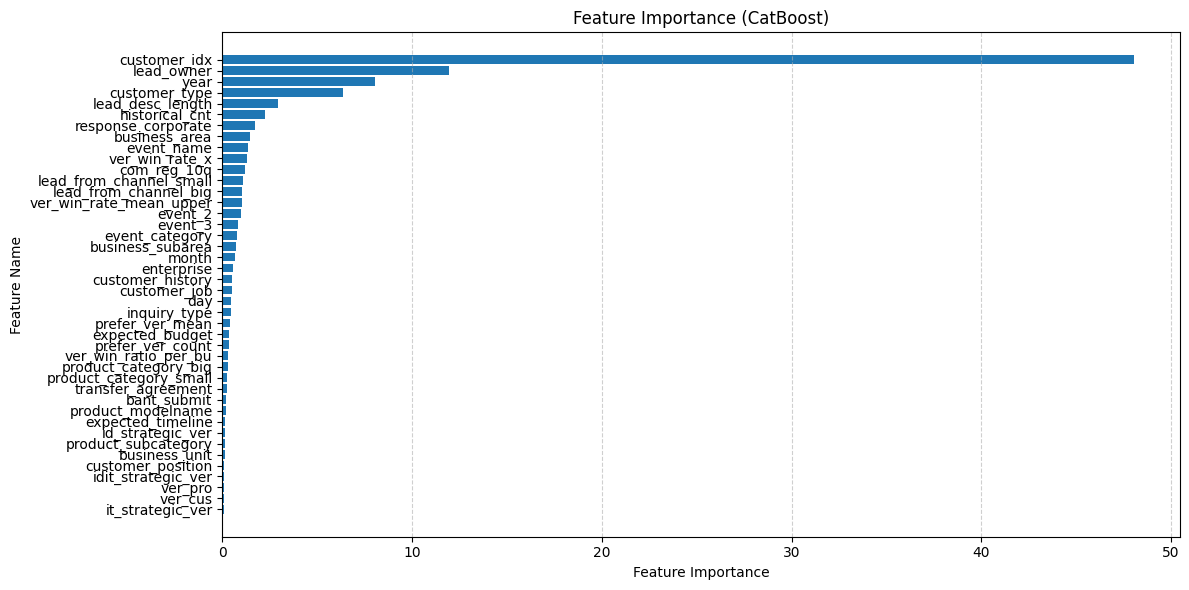

In [207]:

# Get feature importance
feature_importances = model.get_feature_importance()  # Use best iteration
feature_names = x_train.columns.tolist()  # Assuming feature names are in column names

# Sort features by importance (descending)
sorted_idx = np.argsort(feature_importances)[::-1]
feature_importances = feature_importances[sorted_idx]
feature_names = np.array(feature_names)[sorted_idx]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance (CatBoost)")
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top

# Optional: Customize plot (grid, legend, etc.)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()